# Network Attack Detection: 
# Leveraging Machine Learning for Threat Identification

By Sofia Catalan

<a id='sections'></a>

---

## [Background](#background)
- [Topic Description](#description)
- [The UNSW-NB15 Dataset](#dataset)
- [Features Description](#features)
- [Classes: Security Events and Malware](#classes)
## [Model Development](#model-development)
- [Data Cleaning](#data-cleaning)
- [Preprocessing](#preprocessing)
- [Data Analysis](#data-analysis)
    - [Heatmaps and Pairplot](#heat-maps)
    - [Principal Component Analysis (PCA)](#pca)
    - [T-distributed Stochastic Neighbor Embedding (t-SNE)](#tsne)
- [Baseline Classifier: Decision Tree](#tree)
    - [Evaluation](#eval_1)
- [Random Forest Classifier](#forest)
    - [Initial Phase: Testing with Default Parameters](#initial)
    - [Intermediate Phase: Feature Selection and Tuning Hyper Parameters](#intermediate)
    - [Final Phase:  Evaluation of Model](#final)
- [Refocusing Analysis: Normal vs. Attack](#binary)
- [Conclusion](#conclusion)
## [References](#references)

---

<a id='background'></a>
## [Background](#sections)

<a id='description'></a>
### [Topic Description:](#sections)

&emsp;&emsp;Cybercrime is a criminal activity that has been around for decades. The 1960s experienced cyber attacks that targeted communication systems, resulting in the disruption of phone networks [&#91;1&#93;](#references). During the 1980s, hackers began developing malicious programs, including self-replicating code, with the intention to tamper with and exploit individual computers [&#91;1&#93;](#references). By the time the 1990s unfolded, monetary crime experienced a substantial surge as malicious actors had taken advantage of system vulnerabilities and new cyber attack methods [&#91;1&#93;](#references). Today, cybercrime has not abated but continues to pose a significant threat, especially in the realm of information security. Although no agreement has yet been reached on the optimal method to quantify the scale and impact of cybercrime, there is "near-universal agreement that the threat from cybercrime is serious and increasing," with trends suggesting that cybercrime has grown in "terms of its scope, sophistication, number and types of attacks, number of victims, and economical damage" [&#91;2&#93;](#references). 

&emsp;&emsp;&emsp;In light of this, my project aims to harness machine learning as a tool to effectively detect and classify different types of network attacks. This will involve utilizing the UNSW-NB15 Dataset in conjunction with the methodologies discussed in class to develop a machine learning model. In the following report, I will provide an overview of the dataset, including details on the data gathering process, a description of the features, and an explanation of the network attacks that will serve as the objects to be classified. I will also provide my model development process, which involves preparing and refining the data, feature selection and hyperparameter tuning, the evaluation of a baseline classifier as a point of reference, and a final assessment that measures the performance on a more advanced model. Throughout this report, I will incorporate graphs and tables to clearly illustrate the process, as well as discussions on my methodological choices.

<a id='dataset'></a>
### [The UNSW-NB15 Dataset:](#sections)

**Website:** https://research.unsw.edu.au/projects/unsw-nb15-dataset 

This dataset was created in response to the unavailability of a comprehensive network-based dataset capable of reflecting modern network traffic scenarios [&#91;3&#93;](#references). The current benchmark datasets used to evaluate Network Intrusion Detection Systems (NIDSs), such as KDD98 and NSLKDD, have been deemed inadequate due to their outdated nature and redundant or missing information. In a time of "massive growth in computer networks and applications," an updated dataset was needed in order to accurately reflect the evolving characteristics of modern "network traffic patterns and... low footprint attacks" [&#91;3&#93;](#references). This is where the UNSW-NB15 dataset comes in. This dataset was created by simulating modern normal and abnormal network traffic using the IXIA PerfectStorm tool located in the Cyber Range Lab of the Australian Center for Cyber Security (ACCS) [&#91;3&#93;](#references). This tool continuously obtains updated information from the Common Vulnerabilities and Exposures (CVE) [site](https://www.cve.org/). To process this data and create the dataset, Tcpdump, a command-line packet analyzer, was used to capture the network traffic and save it in pcap files. Following this, Argus and Bro-Ids (now called Zeek), two network analysis tools—as well as 12 additional algorithms—were used to extract relevant features and to "analyze the flows of the connection packets" [&#91;3&#93;](#references).


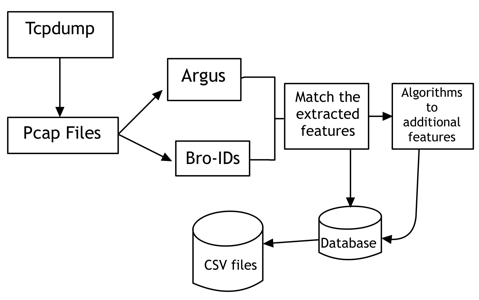

In [1]:
from IPython.display import Image

chart = Image(filename=('Cs345_Project_Chart.png'))
chart

The resulting dataset consists of 2,540,044 records, 47 features, and 10 distinct labels. While one label is used to represent normal activities, the rest of the labels are used to represent nine different types of attacks. A subset of these records was used to create training and testing CSV files. For the purposes of this project, the training set, comprised of 175,341 records, and the testing set, composed of 82,332 records, will be used. Both files contain 43 features, along with 10 labels.

<a id='features'></a>
### [Features Description:](#sections)

The dataset's 47 features can be separated into 6 categories: flow, basic, content, time, general-purpose, and connection features.

**Flow Features:** These features capture the characteristics related to the flow of network traffic from source to destination entities.

| Number  |  Name  | Type  | Description             |
| :------ | :----- | :---: | :---------------------- |
| 1       | srcip  | N     | Source IP address       |
| 2       | sport  | I     | Source port number      |
| 3       | dstip  | N     | Destination IP address  |
| 4       | dsport | I     | Destination port number |
| 5       | proto  | N     | Transaction protocol    |

**Basic Features:** These features provide foundational information of network communications.

| Number  |  Name   | Type  | Description                                                   |
| :------ | :------ | :---: | :------------------------------------------------------------ |
| 6       | state   | N     | The state and its dependent protocol, e.g. ACC, CLO, else (-) |
| 7       | dur     | F     | Record total duration                                         |
| 8       | sbytes  | I     | Source to destination bytes                                   |
| 9       | dbytes  | I     | Destination to source bytes                                   |
| 10      | sttl    | I     | Source to destination time to live                            |
| 11      | dttl    | I     | Destination to source time to live                            |
| 12      | sloss   | I     | Source packets retransmitted or dropped                       |
| 13      | dloss   | I     | Destination packets retransmitted or dropped                  |
| 14      | service | N     | http, ftp, ssh, dns..., else(-)                               |
| 15      | sload   | F     | Source bits per second                                        |
| 16      | dload   | F     | Destination bits per second                                   |
| 17      | spkts   | I     | Source to destination packet count                            |
| 18      | dpkts   | I     | Destination to source packet count                            |

**Content Features:** These features provide insights into the characteristics of the data being transferred.

| Number  |  Name       | Type  | Description                                                             |
| :------ | :---------- | :---: | :---------------------------------------------------------------------- |
| 19      | swin        | I     | Source TCP window advertisement                                         |
| 20      | dwin        | I     | Destination TCP window advertisement                                    |
| 21      | stcpb       | I     | Source TCP sequence number                                              |
| 22      | dtcpb       | I     | Destination TCP sequence number                                         |
| 23      | smeansz     | I     | Mean of the flow packet size transmitted by the src                     |
| 24      | dmeansz     | I     | Mean of the flow packet size transmitted by the dst                     |
| 25      | trans_depth | I     | The depth into the connection of http request/response transaction      |
| 26      | res_bdy_len | I     | The content size of the data transferred from the server's http service |

**Time Features:** These features focus on temporal characteristics related to network communications.

| Number  |  Name       | Type  | Description                                                 |
| :------ | :---------- | :---: | :---------------------------------------------------------- |
| 27      | sjit        | F     | Source jitter (ms)                                          |
| 28      | djit        | F     | Destination jitter (ms)                                     |
| 29      | stime       | T     | record start time                                           |
| 30      | ltime       | T     | record last time                                            |
| 31      | sintpkt     | F     | Source inter-packet arrival time (ms)                       |
| 32      | dintpkt     | F     | Destination inter-packet arrival time (ms)                  |
| 33      | tcprtt      | F     | The sum of 'synack' (34) and 'ackdat' (35) of the TCP       |
| 34      | synack      | F     | The time between the SYN and the SYN_ACK packets of the TCP |
| 35      | ackdat      | F     | The time between the SYN_ACK and the ACK packets of the TCP |

**General-purpose and Connection Features:** According to the author, each general-purpose serves its own purpose from a defense standpoint, and connection features are "solely created to provide defence during attempt to connection scenarios" [&#91;3&#93;](#references).

**General Purpose**
| Number  |  Name            | Type  | Description                                                 |
| :------ | :--------------- | :---: | :---------------------------------------------------------- |
| 36      | is_sm_ips_ports  | B     | If source (1) equals to destination (3) IP addresses and port numbers (2)(4) are equal, this variable takes value 1 else 0 |
| 37      | ct_state_ttl     | I     | Number for each state (6) according to specific range of values for source/destination time to live (10)(11) |
| 38      | ct_flw_http_mthd | I     | Number of flows that has methods such as Get and Post in http service                                        |
| 39      | is_ftp_login     | B     | If the ftp session is accessed by user and password then 1 else 0                                            |
| 40      | ct_ftp_cmd       | I     | Number of flows that has a command in ftp session                                                            |

**Connection Features**
| Number  |  Name            | Type  | Description                                                 |
| :------ | :--------------- | :---: | :---------------------------------------------------------- |
| 41      | ct_srv_src       | I     | Number of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26) |
| 42      | cr_srv_dst       | I     | Number of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26) |
| 43      | ct_dst_ltm       | I     | Number of connections of the same destination address (3) in 100 connections according to the last time (26) |
| 44      | ct_src_ltm       | I     | Number of connections of the same source address (1) in 100 connections according to the last time (26)      |
| 45      | ct_src_dport_ltm | I     | Number of connections of the same source address (1) and the destination port (4) in 100 connections according to the last time (26) |
| 46      | ct_dst_sport_ltm | I     | Number of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26) |
| 47      | ct_dst_src_ltm   | I     | Number of connections of the same source address (1) and the destination address (3) in 100 connections according to the last time (26) |

Legend:  **N**: nominal, **I**: integer, **F**: float, **T**: time, **B**: binary

 As mentioned earlier, the training and testing set provided by the author only contain 43 features. More specifically, the dataset I will use does not contain: (1) *srcip*, (2) *sport*, (3) *dstip*, (4) *dsport*, (29) *stime*, and (30) *ltime*. Furthermore, 2 new features were added: *id* and  *rate*.

<a id='classes'></a>
### [Classes: Security Events and Malware:](#sections)

The dataset contains two columns for labels: *attack_cat* and *Label*. While *attack_cat* contains the names of each type of attack, *Label* provides binary identifiers, with 0 being normal network traffic and 1 signifying an attack. In total, there are 9 network attack classes, and 1 normal class.

| Number  |  Name       | Type  | Description                                                 |
| :------ | :---------- | :---: | :---------------------------------------------------------- |
| 48      | attack_cat  | N     | The name of each attack category. In this dataset, nine categories (e.g., Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, and Worms |
| 49      | label       | B     | 0 for normal and 1 for attack records 


The following are the 9 different types of attacks documented by the dataset:

1. **Fuzzers**: fuzzing is an automated software testing method that involves injecting invalid, random, or malformed/semi-malformed inputs to a program with the objective of uncovering bugs and vulnerabilities. Although this technique is commonly employed to ensure software integrity and protect against potential security breaches, malicious actors themselves use fuzzing to uncover and exploit weaknesses in systems [&#91;8&#93;](#references). 
3. **Analysis**: in the context of this dataset, the Analysis label encompasses a diverse range of cyber attacks, including port scans, spam, and html files penetrations [&#91;3&#93;](#references). 
4. **Backdoor**: a backdoor is a hidden mechanism introduced to a system that facilitates unauthorized access. It is often used by malicious actors as a way to repeatedly gain entry to exploit the system [&#91;9&#93;](#references).
5. **DoS**: a denial-of-service (DoS) is an attack aimed at making a machine or network resource unavailable to its intended users by disrupting services. This attack can be carried out in several different ways, such as exploiting internet protocols, exhausting server resources, and flooding networks with traffic [&#91;10&#93;](#references). 
6. **Exploits**: an exploit is a program or collection of instructions designed to take advantage of a vulnerability in a computer system or software application with the purpose of gaining unauthorized access to resources and leveraging them for malicious purposes. The attacker designs the program with knowledge of a security problem within the operating system or software [&#91;11&#93;](#references).
7. **Generic**: in the context of this dataset, the Generic label is given to a technique that is effective against all block-ciphers irrespective of their specific structure, provided they have the same block and key size [&#91;3&#93;](#references).
8. **Reconnaissance**: this is the process of covertly gathering information about a system, such as security policies, network infrastructure, and host information. Although this is often employed during penetration testing to discover and address system vulnerabilities, hackers carry out this process in order to gather any relevant information that could aid in planning and executing an attack [&#91;12&#93;](#references). In the context of this dataset, the Reconnaissance class represents all the Strikes that can simulate attacks that gather information [&#91;3&#93;](#references).
9. **Shellcode**: this is a small piece of code that is used as the payload to exploit software vulnerabilities [&#91;3&#93;](#references). It consists of a list of commands designed to be injected into a running application, and, upon seizing control, spawns a command interpreter, a shell, enabling the attacker to execute commands on the system and receive back the outputs [&#91;13&#93;](#references).
11. **Worms**: a worm is a type of self-replicating malware that spreads to other computers and networks, exploiting security vulnerabilities to deliver a malicious payload. The objective is to steal sensitive data, manipulate or delete files, and/or gain control of compromised systems [&#91;14&#93;](#references). 

<a id='model-development'></a>
## [Model Development](#sections)

In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

<a id='data-cleaning'></a>
### [Data Cleaning](#sections)

Before working with the dataset, it was necessary to perform some data cleaning. This involved 4 main steps: 
1) removing faulty example(s)
2) removing columns with no meaningful information, such as the **id** and **label** column
3) mapping categorical features to numerical values (**proto**, **state**, and **service**, as well as the labels in **attack_cat**)
4) changing the types to float32 and int32 where applicable


Doing this faciliated analysis for the classifiers to effectively interpret and learn from the data provided. The resulting dataset contains 257,672 examples, 42 features, and a single label column, where 0 denotes normal network traffic and 1-9 represent security events and malware.

As I researched how to convert categorical features to numerical values, three main encodings that I could implement on sklearn stood out, namely: Ordinal Encoding, One-Hot Encoding, and Target Encoding. While Ordinal Encoding is best suited for features with a natural rank order, One-Hot Encoding and Target Encoding work best for nominal features. Furthermore, One-Hot encoding increases dimensionality in proportion to the cardinality of the feature, while Target Encoding does not. Since all of my categorical features are nominal and have high cardinality, Target Encoding seemed like the best option. However, Target Encoding is still in development, so I decided to stick with Ordinal Encoding and One-Hot Encoding and see which one works best.

In [2]:
classes = {
    "Normal": 0,
    "Fuzzers": 1,
    "Analysis": 2,
    "Backdoor": 3,
    "DoS": 4,
    "Exploits": 5,
    "Generic": 6,
    "Reconnaissance": 7,
    "Shellcode": 8,
    "Worms": 9
}

# Clean up datasets by: 
# 1. removing id and label column
# 2. mapping categorical variables to numerical values
# 3. changing the types to float32 or int32 
def map_data(df, encoding):
    df = df.iloc[:, 1:-1]
    df['attack_cat'] = df['attack_cat'].str.strip().map(classes)

    if encoding:
        df = one_hot_encoding(df)
    else:
        df = ordinal_encoding(df)
    df = type_conversion(df)
    return df

def one_hot_encoding(df):
    enc = OneHotEncoder(handle_unknown='ignore') 
    encoded_cols = enc.fit_transform(df[['proto', 'state', 'service']]).todense()
    encoded_df = pd.DataFrame(encoded_cols, columns=enc.get_feature_names_out())
    df = df.drop(columns=['proto', 'state', 'service'])
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    move_labels = df.pop("attack_cat")
    df.insert(len(df.columns), "attack_cat", move_labels)
    return df

def ordinal_encoding(df):
    enc = OrdinalEncoder()
    df[['proto', 'state', 'service']] = enc.fit_transform(df[['proto', 'state', 'service']])
    return df

def type_conversion(df):
    float64_cols = list(df.select_dtypes(include='float64'))
    df[float64_cols] = df[float64_cols].astype('float32')
    int64_cols = list(df.select_dtypes(include='int64'))
    df[int64_cols] = df[int64_cols].astype('int32')
    return df
    
def split_data(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return np.array(X), np.array(y).ravel()

In [3]:
# Read training and testing set as pandas dataframes
training_df = pd.read_csv('training.csv')
testing_df = pd.read_csv('testing.csv')

# Save data from original dataset for future plotting
original_examples = training_df.shape[0] + testing_df.shape[0]
original_features = training_df.shape[1] - 2
original_feature_names = training_df.columns.tolist()[:-2]
original_labels = np.array(list(classes.keys()))

# Remove example with missing 'state' value (faulty example) from training set
training_df = training_df.drop(20808)

# Combine dataframes into one
merged_df = pd.concat([training_df, testing_df])

# Clean training and testing set: Apply One-Hot Encoding
merged_df_ohe = map_data(merged_df, True)

# Clean training and testing set: Apply Ordinal Encoding
merged_df_oe = map_data(merged_df, False)

# Convert dataframe to X matrix with y labels
X_ohe, y_ohe = split_data(merged_df_ohe)
X_oe, y_oe = split_data(merged_df_oe)

# Save data from One-Hot Encoded dataset for future plotting
ohe_examples = X_ohe.shape[0]
ohe_features = X_ohe.shape[1]
ohe_feature_names = merged_df_ohe.columns.tolist()[:-1]
ohe_labels = np.unique(y_ohe)

# Save data from Ordinal Encoded dataset for future plotting
oe_examples = X_oe.shape[0]
oe_features = X_oe.shape[1]
oe_feature_names = merged_df_oe.columns.tolist()[:-1]
oe_labels = np.unique(y_oe)

In [4]:
# Plot table comparing original vs. updated datasets
data = {'Examples(#)' : ["{:,}".format(original_examples), "{:,}".format(ohe_examples), "{:,}".format(oe_examples)],
        'Features' : [original_feature_names, ohe_feature_names, oe_feature_names],
        'Features(#)' : [original_features, ohe_features, oe_features],
        'Labels' : [original_labels, ohe_labels, oe_labels]}
data_info = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
data_info = data_info.rename(index={0: 'Original Dataset', 1: 'One Hot Encoded Dataset', 2: 'Ordinal Encoded Dataset'})
data_info

,Examples(#),Features,Features(#),Labels
Original Dataset,"257,673","[id, dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports]",43,"[Normal, Fuzzers, Analysis, Backdoor, DoS, Exploits, Generic, Reconnaissance, Shellcode, Worms]"
One Hot Encoded Dataset,"257,672","[dur, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports, proto_3pc, proto_a/n, proto_aes-sp3-d, proto_any, proto_argus, proto_aris, proto_arp, proto_ax.25, proto_bbn-rcc, proto_bna, proto_br-sat-mon, proto_cbt, proto_cftp, proto_chaos, proto_compaq-peer, proto_cphb, proto_cpnx, proto_crtp, proto_crudp, proto_dcn, proto_ddp, proto_ddx, proto_dgp, proto_egp, proto_eigrp, proto_emcon, proto_encap, proto_etherip, proto_fc, proto_fire, proto_ggp, proto_gmtp, proto_gre, proto_hmp, proto_i-nlsp, proto_iatp, proto_ib, proto_icmp, proto_idpr, proto_idpr-cmtp, proto_idrp, proto_ifmp, proto_igmp, proto_igp, proto_il, proto_ip, proto_ipcomp, proto_ipcv, proto_ipip, proto_iplt, proto_ipnip, proto_ippc, proto_ipv6, proto_ipv6-frag, proto_ipv6-no, proto_ipv6-opts, proto_ipv6-route, proto_ipx-n-ip, proto_irtp, proto_isis, proto_iso-ip, ...]",195,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
Ordinal Encoded Dataset,"257,672","[dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports]",42,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


After cleaning the data and creating two different datasets, I decided to analyze the class distributions to see if the classes are balanced or not. Since this dataset aims to model current network attack scenarios, I expected a significant disparity:

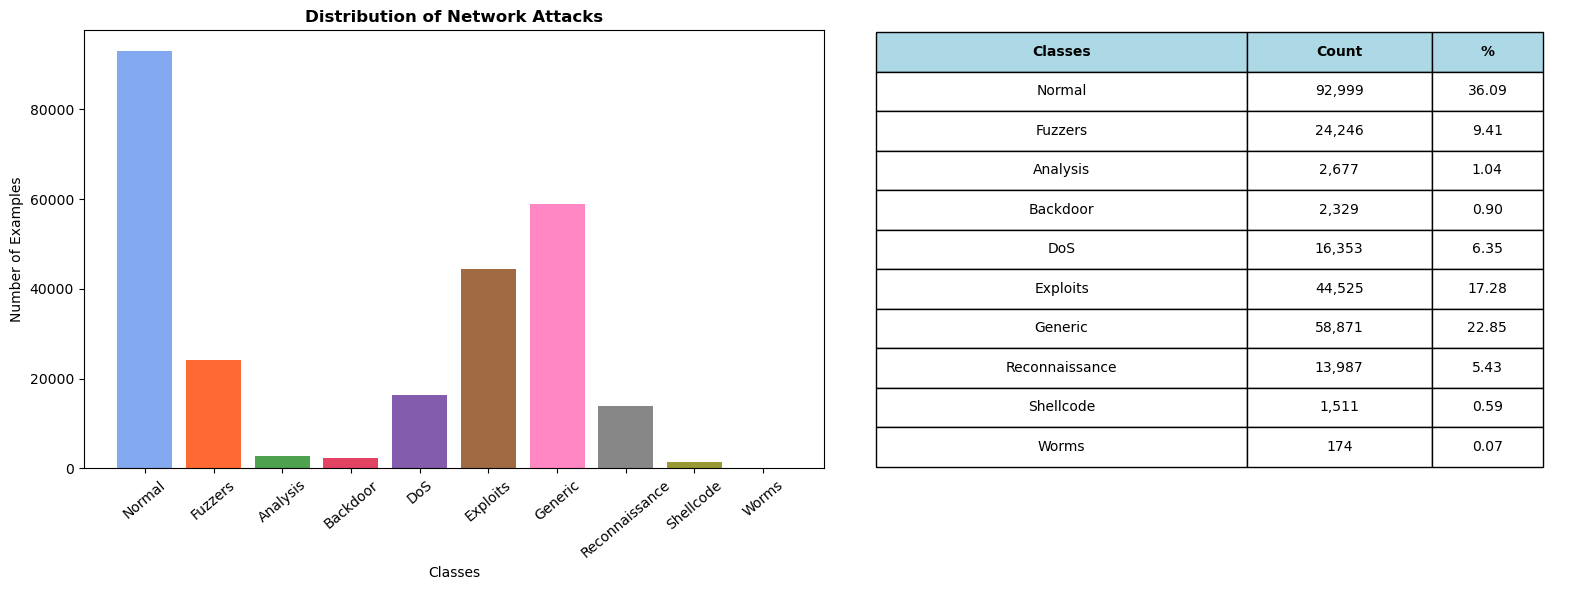

In [6]:
# Plot distribution of classes
class_counts = []
class_names = []
formatted_counts = []
percentage = []

for value in range(10):
    count = np.sum(y_ohe == value)
    formatted_counts.append("{:,}".format(count))
    class_counts.append(count)
    percentage.append("{:.2f}".format((count / 257672)*100))
    class_name = str([key for key in classes if classes[key] == value]).strip("[]'")
    class_names.append(class_name)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'

# Bar Graph
colors = ['cornflowerblue', 'orangered', 'forestgreen', 'crimson', 'rebeccapurple', 'saddlebrown', 'hotpink', 'dimgrey', 'olive', 'lightseagreen']
ax[0].bar(class_names, class_counts, alpha=0.8, color=colors)
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Examples')
ax[0].set_title('Distribution of Network Attacks').set_weight('bold')
ax[0].tick_params(axis='x', rotation=40)

# Table
cell_text = np.vstack((class_names, formatted_counts, percentage)).T
classes_table = ax[1].table(cellText=cell_text, cellLoc='center', colLabels=['Classes', 'Count', '%'], colWidths=[1, 0.5, 0.3],
                            colColours=['lightblue', 'lightblue', 'lightblue'], loc='center')

classes_table[0, 0].get_text().set_weight('bold')
classes_table[0, 1].get_text().set_weight('bold')
classes_table[0, 2].get_text().set_weight('bold')

classes_table.scale(0.5,2.5)
classes_table.auto_set_font_size(True)
ax[1].axis('off')
plt.tight_layout()
plt.show();

From these two graphs, it can be seen that normal network traffic makes up a large part of the dataset. Although it would be expected that in a real-world scenario normal network traffic would be the most prevalent—since most network communications are non-malicious in nature—I was surprised to see that the percentage was not higher than 36%. Following normal traffic, the next three most common classes are Generic, Exploits, and Fuzzers. The proportion of these classes may suggest that these type of network attacks are some of the most prevalent in real-life scenarios, or call for more attention due to their potential to cause significant harm. On the other hand, Worms make up less than a percent of the dataset, again implying either rarity or limited impact in real-life scenarios.

<a id='preprocessing'></a>
### [Preprocessing](#sections)

In [7]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split

For preprocessing, I decided to evaluate five different preprocessing strategies:
1) Normalization
2) Standardization
3) Min-max scaling
4) Max-abs scaling
5) Robust scaling

By transforming the data in this way—ensuring that all data points are in a common scale—I expect the accuracy of the ML models to increase. During the training phases, the performance of both the baseline classifier and the advanced model will be assessed using both processed and unprocessed data, allowing us to determine which approach leads to the highest accuracy.

In [8]:
# For One-Hot Encoded dataset

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y_ohe, test_size=0.2, stratify=y_ohe, shuffle=True, random_state=1)

transformer = Normalizer()
X_ohe_train_norm = transformer.fit_transform(X_ohe_train)
X_ohe_test_norm = transformer.transform(X_ohe_test)

scaler = StandardScaler()
X_ohe_train_std = scaler.fit_transform(X_ohe_train)
X_ohe_test_std = scaler.transform(X_ohe_test)

mmScaler = MinMaxScaler()
X_ohe_train_mm = mmScaler.fit_transform(X_ohe_train)
X_ohe_test_mm = mmScaler.transform(X_ohe_test)

maScaler = MaxAbsScaler()
X_ohe_train_ma = maScaler.fit_transform(X_ohe_train)
X_ohe_test_ma = maScaler.transform(X_ohe_test)

rScaler = RobustScaler()
X_ohe_train_r = rScaler.fit_transform(X_ohe_train)
X_ohe_test_r = rScaler.transform(X_ohe_test)

print("Training set shape for One-Hot Encoding:", X_ohe_train.shape)

# For Ordinal Encoded dataset
X_oe_train, X_oe_test, y_oe_train, y_oe_test = train_test_split(X_oe, y_oe, test_size=0.2, stratify=y_oe, shuffle=True, random_state=1)

X_oe_train_norm = transformer.fit_transform(X_oe_train)
X_oe_test_norm = transformer.transform(X_oe_test)

X_oe_train_std = scaler.fit_transform(X_oe_train)
X_oe_test_std = scaler.transform(X_oe_test)

X_oe_train_mm = mmScaler.fit_transform(X_oe_train)
X_oe_test_mm = mmScaler.transform(X_oe_test)

X_oe_train_ma = maScaler.fit_transform(X_oe_train)
X_oe_test_ma = maScaler.transform(X_oe_test)

X_oe_train_r = rScaler.fit_transform(X_oe_train)
X_oe_test_r = rScaler.transform(X_oe_test)

print("Training set shape for Ordinal Encoding:", X_oe_train.shape)

Training set shape for One-Hot Encoding: (206137, 195)
Training set shape for Ordinal Encoding: (206137, 42)


After seeing that my One-Hot Encoding resulted in 195 features, I decided to employ PCA analysis on the continuous features to address this high-dimensionality. However, knowing that PCA behaves differently depending on the preprocessing strategy implemented, I will try to determine which one would be the most appropriate to do PCA on. I'll do this by first creating a subset of the original dataset consisting of only the continuous features, then creating training splits of the dataset on each of the five scalers (+ No preprocessing), and then doing PCA on all of them and visualizing their outcome.

In [9]:
# Obtain a subset of continuous features 
continuous_features_cols = list(type_conversion(merged_df).select_dtypes(include='float32')) 
X_c = np.array(merged_df[continuous_features_cols].copy())

y_c = y_oe # Either y_ohe and y_oe would work as they retain the order

# Obtain a subset of continuous features + Label for pairplot
continuous_features_cols.append('attack_cat') 
continuous_dataframe_label = merged_df[continuous_features_cols].copy()

X_train_c, _, y_train_c, _ = train_test_split(X_c, y_c, test_size=0.2, stratify=y_oe, shuffle=True, random_state=1)

# [1] Normalize
transformer = Normalizer()
X_train_norm_c = transformer.fit_transform(X_train_c)

# [2] Standardize
scaler = StandardScaler()
X_train_std_c = scaler.fit_transform(X_train_c)

# [3] Min-Max Scaling
mmScaler = MinMaxScaler()
X_train_mm_c = mmScaler.fit_transform(X_train_c)

# [4] Max-Abs Scaling
maScaler = MaxAbsScaler()
X_train_ma_c = maScaler.fit_transform(X_train_c)

# [5] Robust Scaling
rScaler = RobustScaler()
X_train_r_c = rScaler.fit_transform(X_train_c)

# Plot table with updated dataset
data = {'Names of Continuous Features' : [continuous_features_cols[:-1]],
        'Number of Continuous Features' : [len(continuous_features_cols[:-1])],
       }
data_info = pd.DataFrame(data)
data_info

,Names of Continuous Features,Number of Continuous Features
0,"[dur, rate, sload, dload, sinpkt, dinpkt, sjit, djit, tcprtt, synack, ackdat]",11


<a id='data-analysis'></a>
### [Data Analysis](#sections)

<a id='heat-maps'></a>
#### [Heatmaps and Pairplot](#sections)

In [10]:
import seaborn as sns

Before doing PCA, I wanted to visualize the correlation between all features. To do this, I first created 6 different heatmaps for the One-Hot Encoded training splits, one for each scaler (+ No Preprocessing). After seeing which scaler works best to visualize correlation, I created a single heatmap for the Ordinal Encoded training split using that scaler.

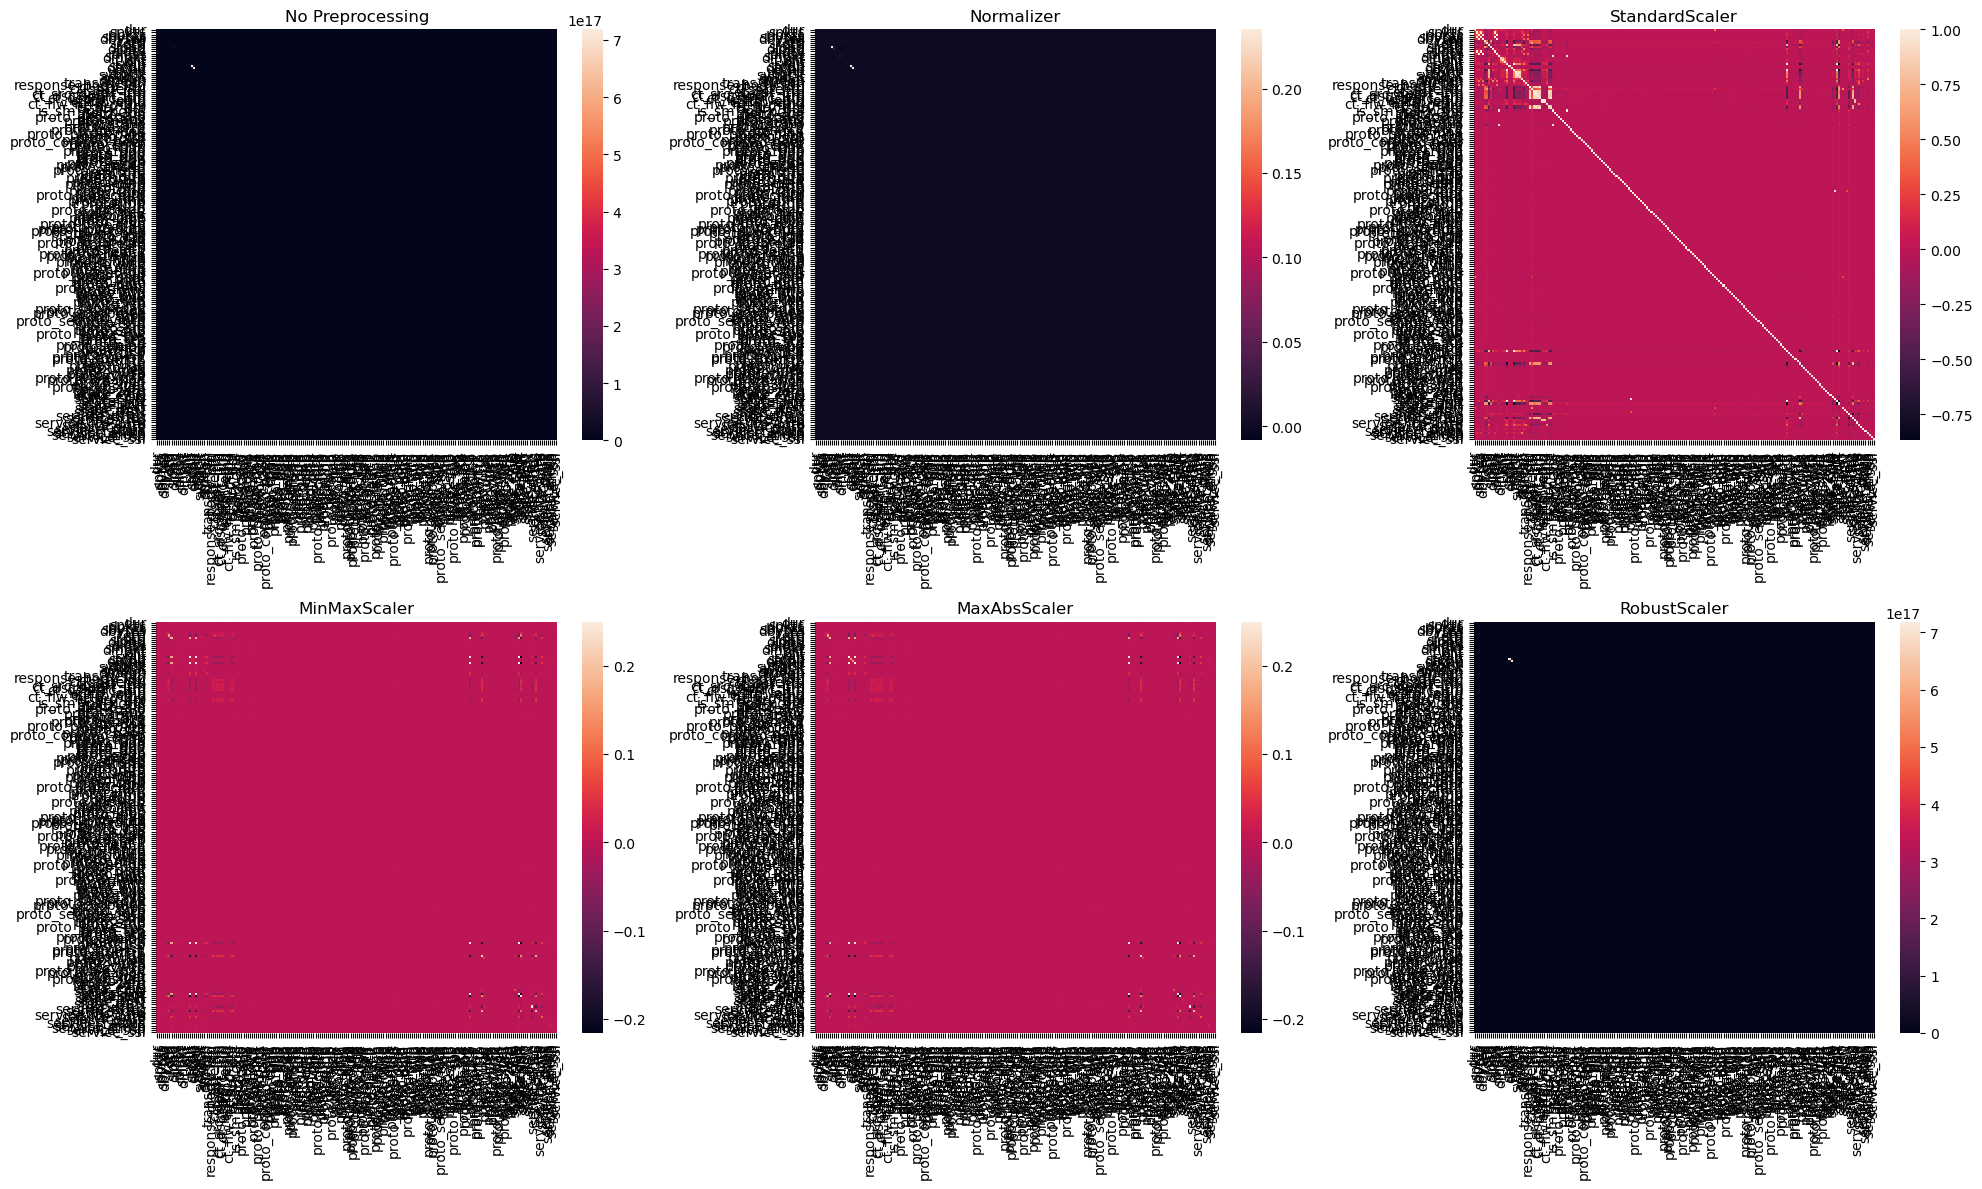

In [11]:
# For One Hot Encoding
covariance_matrix0 = np.cov(X_ohe_train, rowvar=False)
covariance_matrix1 = np.cov(X_ohe_train_norm, rowvar=False)
covariance_matrix2 = np.cov(X_ohe_train_std, rowvar=False)
covariance_matrix3 = np.cov(X_ohe_train_mm, rowvar=False)
covariance_matrix4 = np.cov(X_ohe_train_ma, rowvar=False)
covariance_matrix5 = np.cov(X_ohe_train_r, rowvar=False)

features_list = merged_df_ohe.columns.tolist()[:-1]

fig, ax = plt.subplots(2, 3, figsize=(20, 12))
sns.heatmap(covariance_matrix0, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[0, 0])
ax[0, 0].set_title('No Preprocessing')

sns.heatmap(covariance_matrix1, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[0, 1])
ax[0, 1].set_title('Normalizer')

sns.heatmap(covariance_matrix2, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[0, 2])
ax[0, 2].set_title('StandardScaler')

sns.heatmap(covariance_matrix3, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[1, 0])
ax[1, 0].set_title('MinMaxScaler')

sns.heatmap(covariance_matrix4, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[1, 1])
ax[1, 1].set_title('MaxAbsScaler')

sns.heatmap(covariance_matrix5, xticklabels=features_list, yticklabels=features_list, fmt=".2f", ax=ax[1, 2])
ax[1, 2].set_title('RobustScaler')

plt.tight_layout()
plt.show();

First, from the heat maps, I can conclude that the the Standard Scaler is better for visualizing correlation between variables. Second, since the dimensionality of the dataset increased a lot, the correlation between variables other than the ones that make up **proto**, **state**, and **service** are very hard to see, which is an issue that is anticipated to be remediated with the Ordinal Encoded training split.

Using the Standard Scaler to visualize correlations:


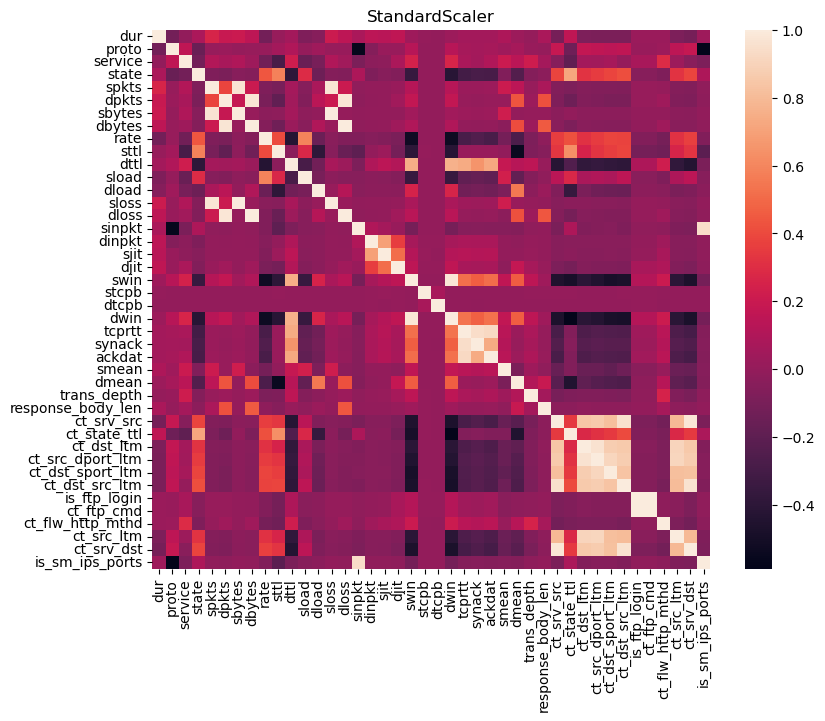

In [12]:
# For Ordinal Encoding
covariance_matrix2 = np.cov(X_oe_train_std, rowvar=False)
features_list = merged_df_oe.columns.tolist()[:-1]

fig = plt.figure(figsize=(9,7))
sns.heatmap(covariance_matrix2, xticklabels=features_list, yticklabels=features_list, fmt=".2f")
plt.title('StandardScaler')
print("Using the Standard Scaler to visualize correlations:")
plt.show();

This heatmap shows a variety of variables that exhibit strong positive correlations, such as:

- **sbytes** & **spkts**, **sloss** & **spkts**, and **sbytes** & **sloss**. This indicates that there's a correlation between the number of source packets, the size of those packets, and the number of those packets retransmitted or dropped. These features are all from the Basic feature category.
- **dbytes** & **dpkts**, **dloss** & **dpkts**, and **dbytes** & **dloss**. Like for the source packets, there seems to be a correlation between another set of Basic features: the number of destination packets, the number of those retransmitted or dropped, and their size.
- **dwin** & **swin**. This indicates a strong relationship between the source and destination TCP window advertisement
- **ct_dst_src_ltm** & **ct_srv_src** and **ct_srv_dst** & **ct_srv_src**. These features are all from the Connection feature category, indicating a correlation between connection stats.
- ...

As for strong negative correlations, we have
- **rate & dwin**, **rate & swin**, **rate** & **dttl**. This indicates a negative correlation between the rate of the packet transmission with the window advertisements and the destination to source time to live.
- **swin** & a number of connection features and **dwin** & a number of connection features.
- ...

Other things to note are that: **stcpb** and **dtcpb**, the source/destination TCP sequence numbers, don't seem to exhibit any kind of relationship. Also, there seems to be a mild cluster of negative relationships between connection features and content features, and a mild cluster of positive relationshis between connection features with each other.

In [59]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

Apart from analyzing the correlation between features, the next thing I wanted to see is if there are any pairwise relationships that can be visualized between the continuous features. I did this using pairplot from the seaborn library.

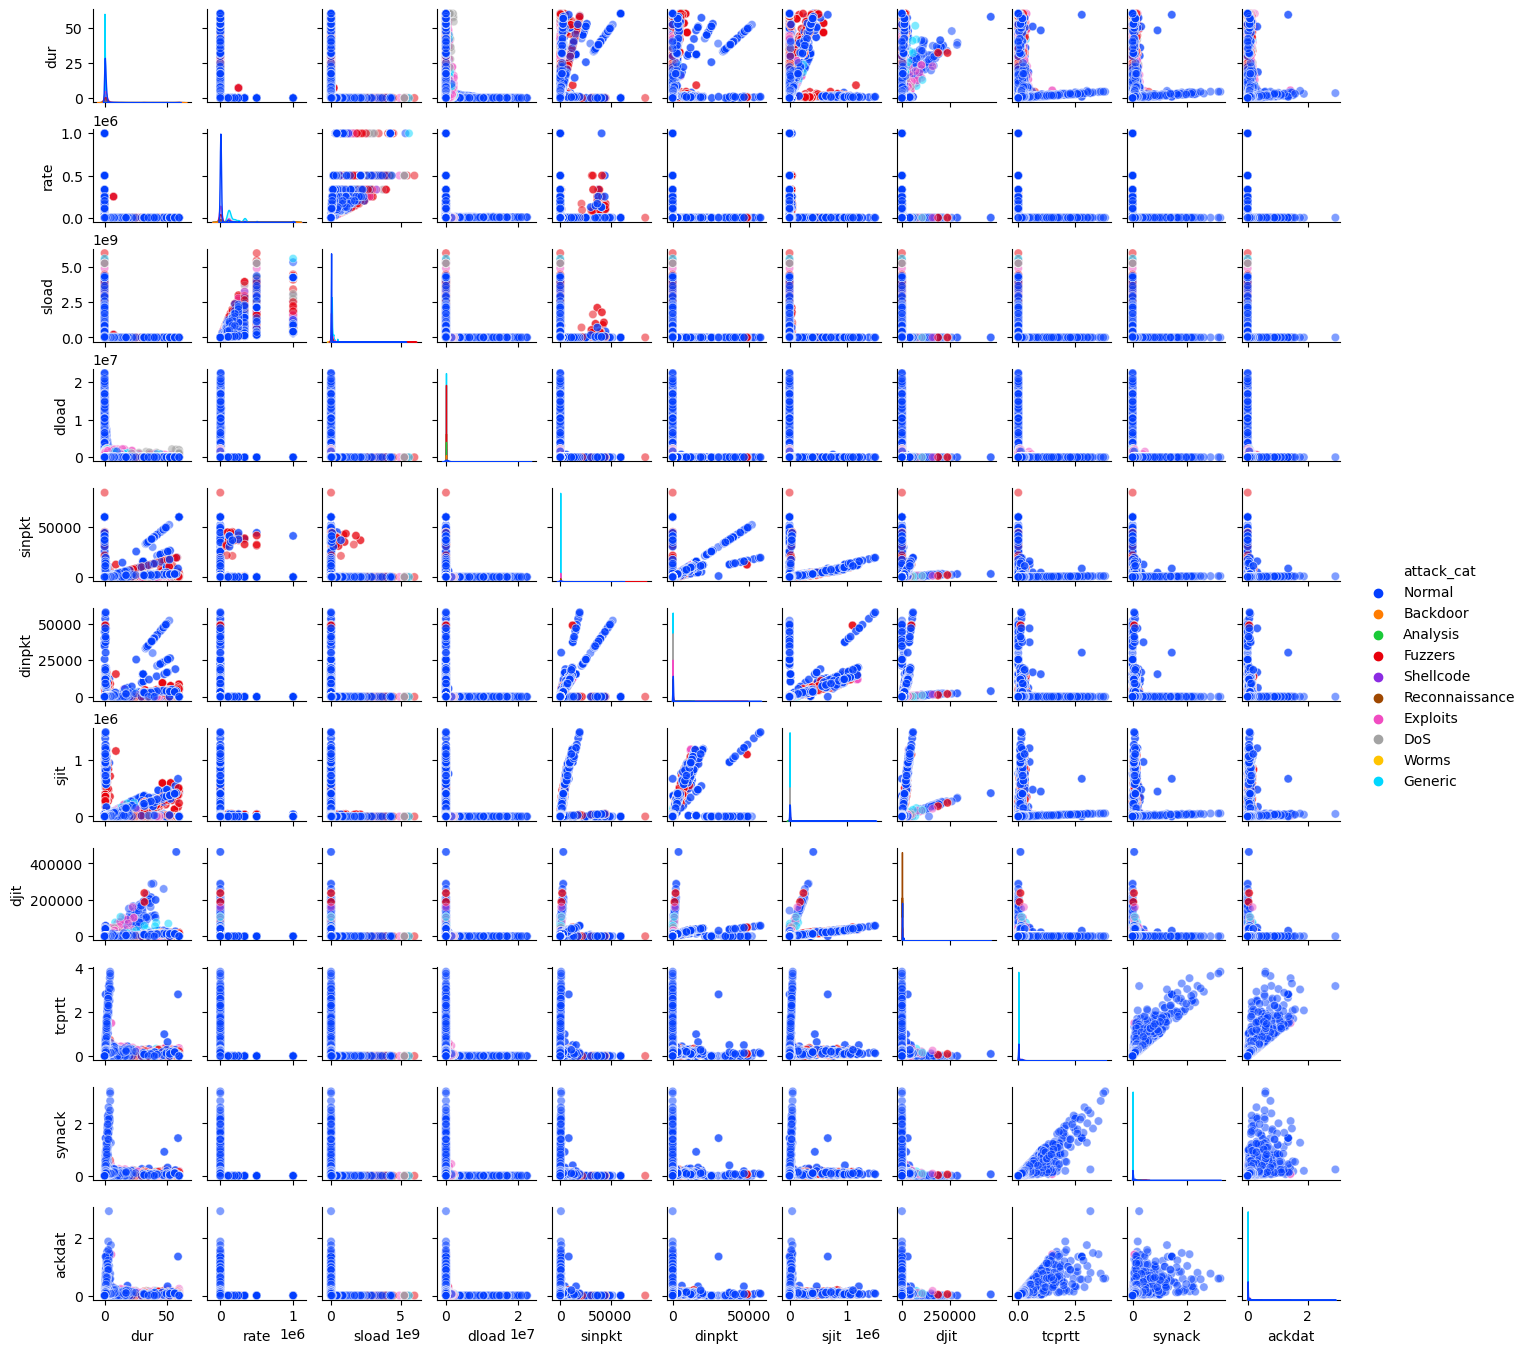

In [60]:
sns.pairplot(continuous_dataframe_label, hue='attack_cat', palette='bright', height=1.25, plot_kws={'alpha':0.5});

From the pairplot, I can't makeout any pairwise relationships, except that along **rate**, there seems to be a separation between normal network traffic and Generic network traffic.

<a id='pca'></a>
#### [Principal Component Analysis (PCA)](#sections)

In [15]:
from sklearn.decomposition import PCA

Since Principal Component Analysis is only meaningful with continuous variables rather than categorical, I previously created 6 training splits (one for each scaler + no preprocessing) of the data with the 11 continuous features that makeup the dataset using *X_c* and y_c. In the following section, I will graph the first 2 principal components on each of the scalers to see what kind of information can be derived from the variance.

In [16]:
num_components = 11
pca = PCA(n_components=num_components)

# No Preprocessing, Normalization, Standardization, Min-Max Scaling, Max-Abs Scaling, Robust Scaling
X_pca_data = []
explained_variance_data = []
X_train_data_c = [X_train_c, X_train_norm_c, X_train_std_c, X_train_mm_c, X_train_ma_c, X_train_r_c]

for X_t in X_train_data_c:
    X_pca_data.append(pca.fit_transform(X_t))
    explained_variance_data.append(np.cumsum(pca.explained_variance_ratio_))

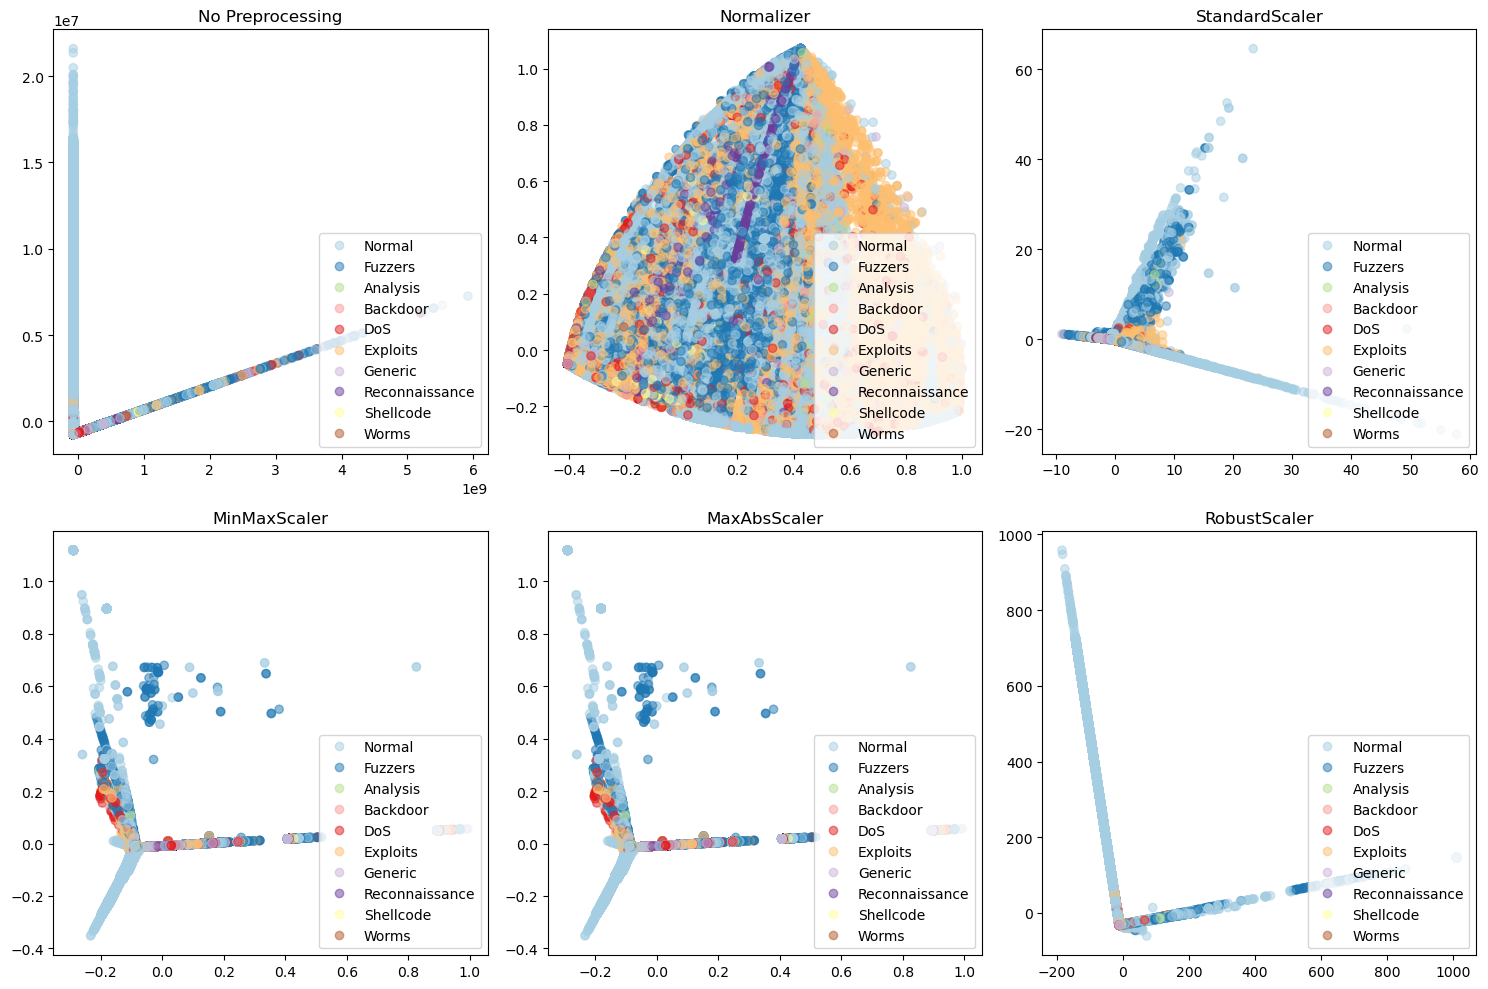

In [17]:
# Plot first two components on each preprocessed data
rows = 2
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 10))   

scatter0 = ax[0,0].scatter(X_pca_data[0][:,0], X_pca_data[0][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[0, 0].set_title('No Preprocessing')
ax[0, 0].legend(handles=scatter0.legend_elements()[0], labels=class_names, loc=4)

scatter1 = ax[0,1].scatter(X_pca_data[1][:,0], X_pca_data[1][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[0, 1].set_title('Normalizer')
ax[0, 1].legend(handles=scatter1.legend_elements()[0], labels=class_names, loc=4)

scatter2 = ax[0,2].scatter(X_pca_data[2][:,0], X_pca_data[2][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[0, 2].set_title('StandardScaler')
ax[0, 2].legend(handles=scatter2.legend_elements()[0], labels=class_names, loc=4)

scatter3 = ax[1,0].scatter(X_pca_data[3][:,0], X_pca_data[3][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[1, 0].set_title('MinMaxScaler')
ax[1, 0].legend(handles=scatter3.legend_elements()[0], labels=class_names, loc=4)

scatter4 = ax[1,1].scatter(X_pca_data[4][:,0], X_pca_data[4][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[1, 1].set_title('MaxAbsScaler')
ax[1, 1].legend(handles=scatter4.legend_elements()[0], labels=class_names, loc=4)

scatter5 = ax[1,2].scatter(X_pca_data[5][:,0], X_pca_data[5][:,1], alpha=0.5, c=y_train_c, cmap=plt.cm.Paired)
ax[1, 2].set_title('RobustScaler')
ax[1, 2].legend(handles=scatter5.legend_elements()[0], labels=class_names, loc=4)

plt.tight_layout()
plt.show();

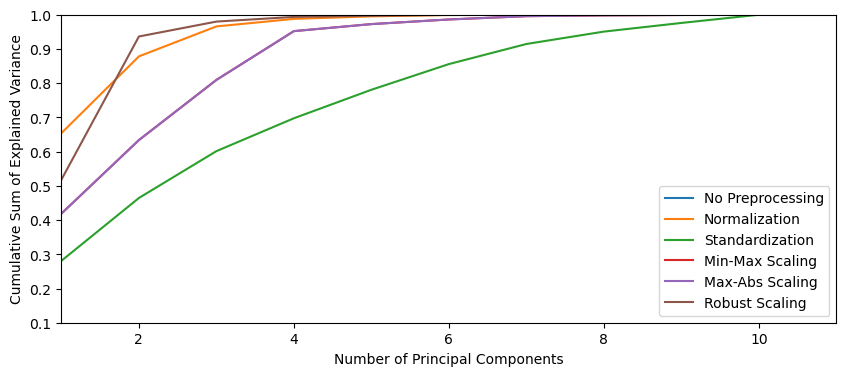

In [18]:
# Plot cumulative explained variance for each scaler
num_components = [1,2,3,4,5,6,7,8,9,10,11]

scalers_list = ['No Preprocessing', 'Normalization', 'Standardization', 'Min-Max Scaling', 'Max-Abs Scaling', 'Robust Scaling']
fig = plt.figure(figsize=(10,4))
for i in range(len(X_pca_data)):
    plt.plot(num_components, explained_variance_data[i], label=scalers_list[i])
    
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.ylim(0.1,1)
plt.xlim(1,11)
plt.legend()
plt.show();

From the scatterplots of the two principal components, and the line graph showing No. of Principal Components vs. Cumulative Sum of Explained Variance, I can conclude that PCA is not applicable for the continuous features. The scatterplots show that the first two principal components do not provide a clear separation of datapoints, so not much variance/information can be retained. As for the line graph, a thing to note is that Robust Scaling deceivingly says we only need 2 principal components, but this is because the second principal component makes a clear separation between Normal network traffic and the 9 Network attacks. The No Preprocessing scatterplot also shows this. 

<a id='tsne'></a>
#### [T-distributed Stochastic Neighbor Embedding (t-SNE)](#sections)

In [19]:
from sklearn.manifold import TSNE

Out of curiosity, I also played around with the parameters of t-SNE to see if I could get a better visualization, but that was not the case.

In [20]:
num_components = 2
tsne = TSNE(n_components=num_components, learning_rate=800, perplexity=15, n_jobs=-1)
# No Preprocessing, Normalization, Standardization, Min-Max Scaling, Max-Abs Scaling, Robust Scaling
X_train_data = [X_train_c, X_train_norm_c, X_train_std_c, X_train_mm_c, X_train_ma_c, X_train_r_c]
X_tsne_data = []

for X_t in X_train_data:
    X_tsne_data.append(tsne.fit_transform(X_t[:1000]))

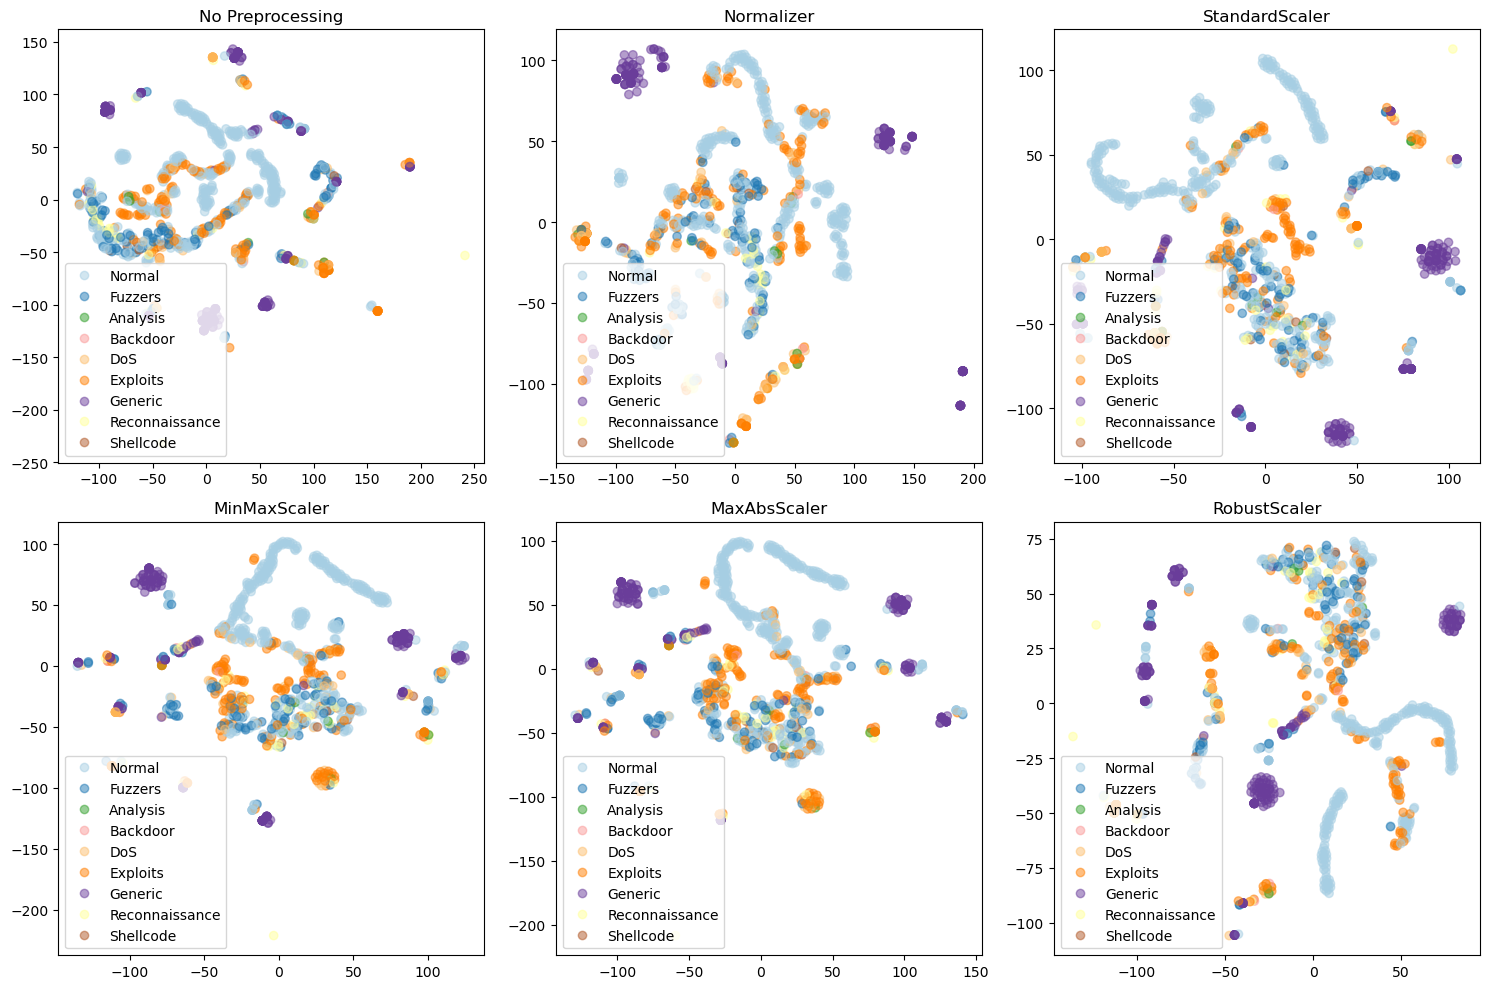

In [21]:
# Plot first two components on each preprocessed data
rows = 2
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 10))

scatter0 = ax[0,0].scatter(X_tsne_data[0][:,0], X_tsne_data[0][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[0, 0].set_title('No Preprocessing')
ax[0, 0].legend(handles=scatter0.legend_elements()[0], labels=class_names, loc=3)

scatter1 = ax[0,1].scatter(X_tsne_data[1][:,0], X_tsne_data[1][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[0, 1].set_title('Normalizer')
ax[0, 1].legend(handles=scatter1.legend_elements()[0], labels=class_names, loc=3)

scatter2 = ax[0,2].scatter(X_tsne_data[2][:,0], X_tsne_data[2][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[0, 2].set_title('StandardScaler')
ax[0, 2].legend(handles=scatter2.legend_elements()[0], labels=class_names, loc=3)

scatter3 = ax[1,0].scatter(X_tsne_data[3][:,0], X_tsne_data[3][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[1, 0].set_title('MinMaxScaler')
ax[1, 0].legend(handles=scatter3.legend_elements()[0], labels=class_names, loc=3)

scatter4 = ax[1,1].scatter(X_tsne_data[4][:,0], X_tsne_data[4][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[1, 1].set_title('MaxAbsScaler')
ax[1, 1].legend(handles=scatter4.legend_elements()[0], labels=class_names, loc=3)

scatter5 = ax[1,2].scatter(X_tsne_data[5][:,0], X_tsne_data[5][:,1], alpha=0.5, c=y_train_c[:1000], cmap=plt.cm.Paired)
ax[1, 2].set_title('RobustScaler')
ax[1, 2].legend(handles=scatter5.legend_elements()[0], labels=class_names, loc=3)

plt.tight_layout()
plt.show();

<a id='tree'></a>
### [Baseline Classifier: Decision Tree](#sections)

Originally, I arbitrarily opted to use the KNeighborsClassifier() as my baseline due to my limited knowledge about the dataset. Then, after familiarizing myself with the dataset and examining the following table:

| Algorithm /<br/>Characteristic |  logistic<br/> regression |  KNN  | decision<br/>trees  | ensemble<br/>methods |  feed-forward<br/>networks | SVM |
|:-----------|:-------:|:--------:|:-------:|:------:|:-------:|:------:|
| **Predictive power** | ✔️ | ✔️ | ❌ | ✔️✔️ | ✔️✔️ | ✔️✔️ |
| **Interpretability** | ✔️ | ✔️ | ✔️ | ❌ | ❌ | ❌ |
| **Scalability<br/>(large N)** | ✔️✔️ | ❌ | ✔️✔️ | ✔️✔️ | ❌ | ✔️✔️ |
| **Scalability<br/>(large d)** | ✔️ | ❌ | ❌ | ✔️✔️ | ✔️ | ✔️✔️ |
| **Handle categorical<br/>data** | ❌ | ❌ | ✔️✔️ | ✔️✔️ | ❌ | ❌ |
| **Handle missing<br/>data** | ❌ | ❌ | ✔️✔️ | ✔️✔️ | ❌ | ❌ |

Legend:  ✔️✔️: high performer,✔️: mid performer, ❌: low performer

I decided to shift away from my initial decision of using KNeighborsClassifier() as my base classifier and instead decided to use the DecisionTreeClassifier(). While the KNeighborsClassifier() demonstrates to be a mid-performer in predictive power and interpretability, it falls short in scaling along examples/features as well as handling categorical data. Given that the UNSW-NB15 dataset is high-dimensional and its features include categorical data, I decided to use the DecisionTreeClassifier(). This classifier offers interpretability, scalability along the examples (but not so much for features), and it can handle categorical data.

<a id='eval_1'></a>
### [Evaluation](#sections)

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
def accuracy_table(cell_text, cell_text2):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plt.rcParams['font.family'] = 'DejaVu Sans'
    classes_table = ax[0].table(cellText=cell_text, cellLoc='center', colLabels=['Type of Scaler', 'Accuracy'], colWidths=[0.3, 0.5],
                            colColours=['lightblue', 'lightblue'], loc='center')
    classes_table[0, 0].get_text().set_weight('bold')
    classes_table[0, 1].get_text().set_weight('bold')
    classes_table.scale(1,2.5)
    classes_table.auto_set_font_size(True)
    ax[0].axis('off')
    ax[0].set_title('One-Hot Encoding', y=0.85)
    classes_table2 = ax[1].table(cellText=cell_text2, cellLoc='center', colLabels=['Type of Scaler', 'Accuracy'], colWidths=[0.3, 0.5],
                            colColours=['lightblue', 'lightblue'], loc='center')

    classes_table2[0, 0].get_text().set_weight('bold')
    classes_table2[0, 1].get_text().set_weight('bold')
    classes_table2.scale(1,2.5)
    classes_table2.auto_set_font_size(True)
    ax[1].axis('off')
    ax[1].set_title('Ordinal Encoding', y=0.85)

    plt.tight_layout()
    plt.show();


def evaluate_accuracy(X_train, X_test, y_train, y_test):
    tree = DecisionTreeClassifier(random_state=1)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    return np.mean(y_test == y_pred)

X_ohe_train_data = [
    [X_ohe_train, X_ohe_test], 
    [X_ohe_train_norm, X_ohe_test_norm], 
    [X_ohe_train_std, X_ohe_test_std], 
    [X_ohe_train_mm, X_ohe_test_mm], 
    [X_ohe_train_ma, X_ohe_test_ma], 
    [X_ohe_train_r, X_ohe_test_r]
]

X_oe_train_data = [
    [X_oe_train, X_oe_test], 
    [X_oe_train_norm, X_oe_test_norm], 
    [X_oe_train_std, X_oe_test_std], 
    [X_oe_train_mm, X_oe_test_mm],  
    [X_oe_train_ma, X_oe_test_ma], 
    [X_oe_train_r, X_oe_test_r]
]

tree_ohe_accuracy = []
tree_oe_accuracy = []

for X_p in X_ohe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_ohe_train, y_ohe_test)
    tree_ohe_accuracy.append("{:.2f}%".format(accuracy * 100))
    
for X_p in X_oe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_oe_train, y_oe_test)
    tree_oe_accuracy.append("{:.2f}%".format(accuracy * 100))

cell_text = np.vstack((scalers_list, tree_ohe_accuracy)).T
cell_text2 = np.vstack((scalers_list, tree_oe_accuracy)).T

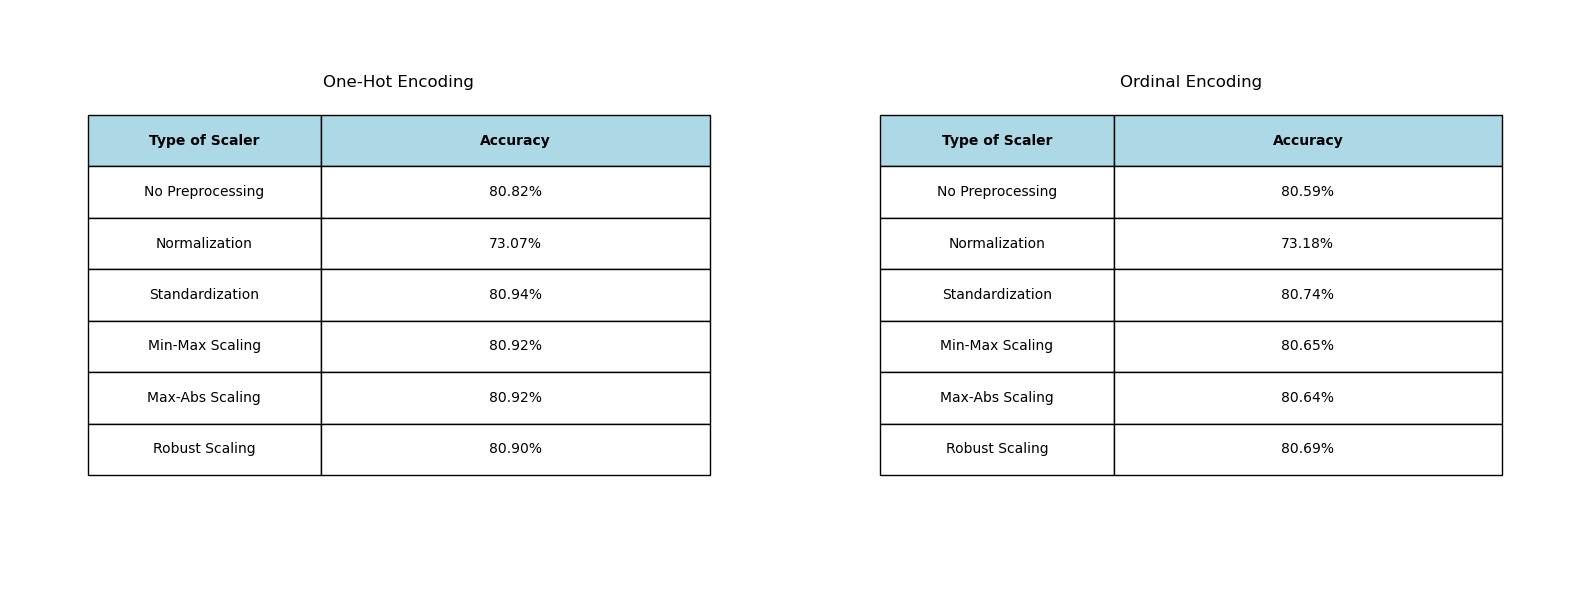

In [24]:
accuracy_table(cell_text, cell_text2)

From the results of the base classifier, it can be seen that:

<ins>**For the One-Hot Encoded dataset**</ins>: Standardization achieved the highest accuracy of **80.94%**, and Normalization resulted in the lowest accuracy of **73.07%**.

<ins>**For the Ordinal Encoded dataset**</ins>: the highest accuracy of **80.74%** was achieved with Standardization, while Normalization led to the lowest accuracy of **73.18%**.

<ins>**Overall**</ins>: the One-Hot Encoded dataset with Standardization achieved the highest accuracy of **80.94%**, while Normalization in the One-Hot Encoded dataset resulted in the lowest accuracy of **73.07%**.

**Observations**:
- Normalization is a poor scaler for this dataset
- The result of standardization achieving the highest accuracy should be taken with a grain of salt, considering there is a negligible difference in the accuracy results (except for normalization).

<a id='forest'></a>
### [Random Forest Classifier](#sections) 

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix

<a id='initial'></a>
#### [Initial Phase: Testing with Default Parameters](#sections)

In [26]:
def evaluate_accuracy(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(n_jobs=-1, random_state=1)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    return np.mean(y_test == y_pred)

forest_ohe_accuracy = []
forest_oe_accuracy = []

for X_p in X_ohe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_ohe_train, y_ohe_test)
    forest_ohe_accuracy.append("{:.2f}%".format(accuracy * 100))
    
for X_p in X_oe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_oe_train, y_oe_test)
    forest_oe_accuracy.append("{:.2f}%".format(accuracy * 100))

cell_text = np.vstack((scalers_list, forest_ohe_accuracy)).T
cell_text2 = np.vstack((scalers_list, forest_oe_accuracy)).T

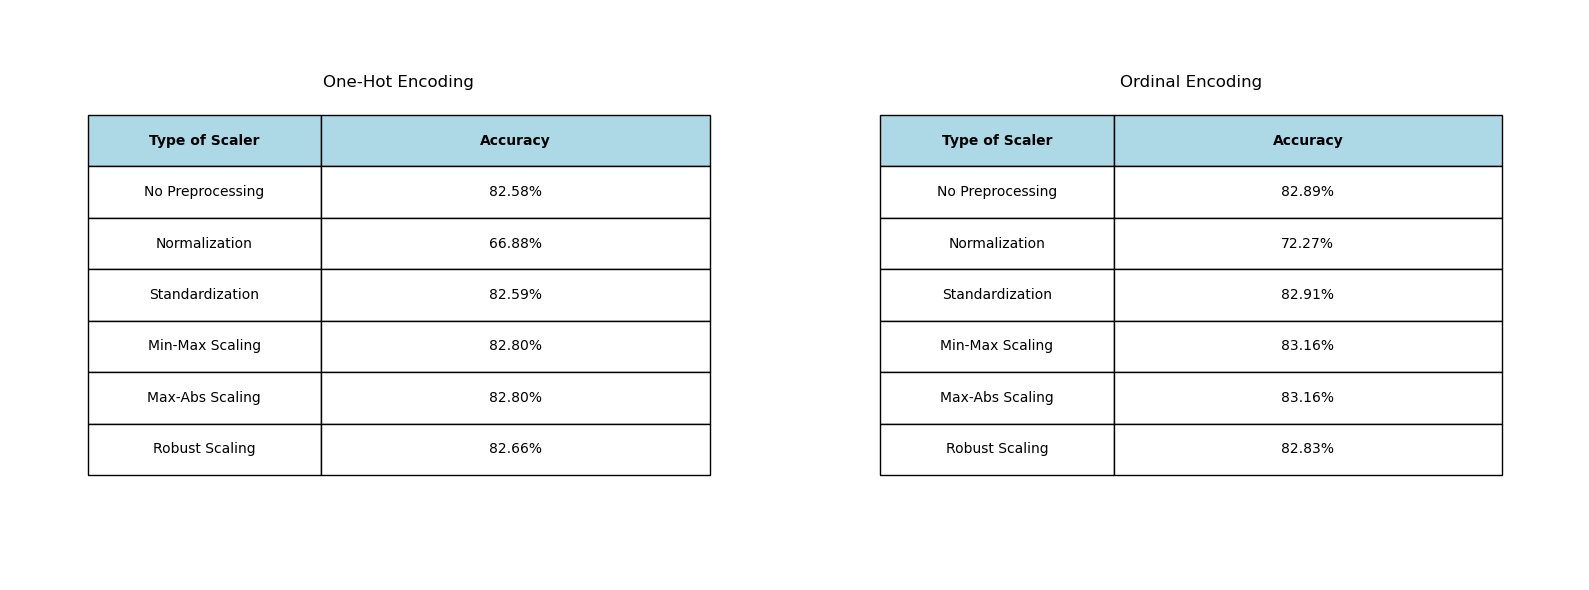

In [27]:
accuracy_table(cell_text, cell_text2)

As for the results of the Random Forest Classifier with default parameters:

<ins>**For the One-Hot Encoded dataset**</ins>: Min-Max Scaling and Max-Abs Scaling obtained the highest accuracy of **82.80%**, while Normalization was the scaler with the lowest accuracy of **66.88%**.

<ins>**For the Ordinal Encoded dataset**</ins>: Min-Max Scaling and Max-Abs Scaling resulted in the highest accuracy of **83.16%**, while Normalization led to the lowest accuracy of **72.27%**.

<ins>**Overall**</ins>: the Ordinal Encoded dataset with Min-Max Scaling and Max-Abs Scaling achieved the highest accuracy of **83.16%**, while Normalization in the One-Hot Encoded dataset resulted in the lowest accuracy of **66.88%**.

**Observations**:
- Normalization continues to be a poor scaler for this dataset

#### Confusion Matrix

I decided to incorporate the confusion matrix in order to see which classes tend to be confused with each other. I also made the choice to visualize the classifier that got the highest accuracy, which is the Ordinal Encoded data scaled with the MinMaxScaler().

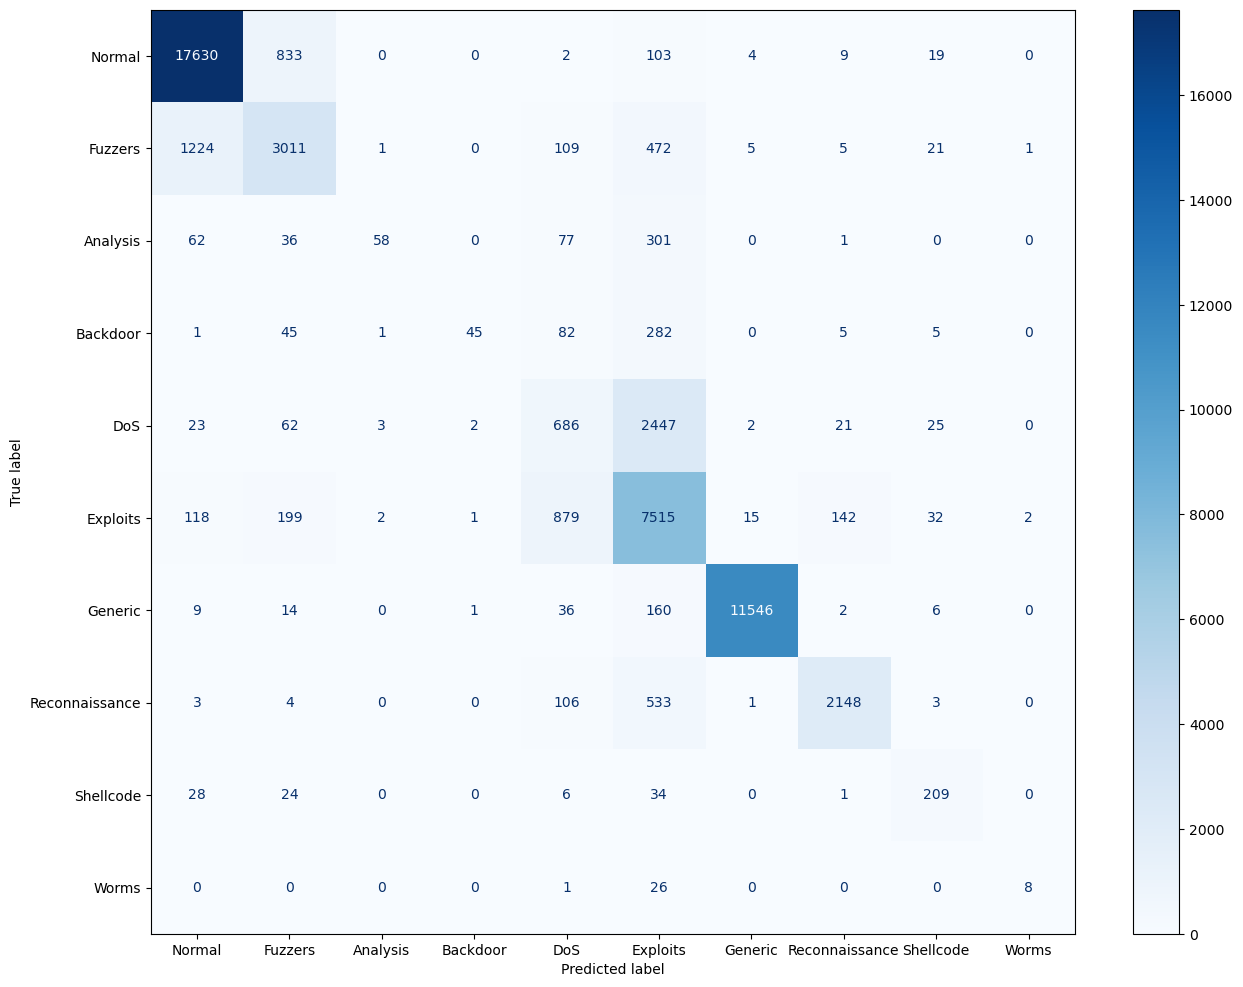

In [28]:
# Use Ordinal Encoded data with Min-Max Scaler 
forest = RandomForestClassifier(n_jobs=-1, random_state=1)
forest.fit(X_oe_train_mm, y_oe_train)
y_pred = forest.predict(X_oe_test_mm)
matrix = confusion_matrix(y_oe_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,12))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

Although the confusion matrix reveals several misclassifications, the main ones are that Exploits tend to be confused with DoS and that Fuzzers tend to be confused with Normal network traffic. 

<a id='intermediate'></a>
#### [Intermediate Phase: Feature Selection and Tuning Hyper Parameters](#sections)

In [64]:
from sklearn.feature_selection import RFECV

Seeing that the highest score of the Random Forest classifier is **83.16%**, I will do Feature Selection and Hyper Parameter Tuning to improve the results. However, since Random Forest already works well out of the box, I don't expect the final accuracy to increase by much.

##### Feature Selection

Before doing feature selection, I was curious to see what the most important features were for the Random Forest Classifier in the initial phase and how they'd compare with the results from RFECV. Again, I will be using the Ordinal Encoded data scaled with Min-Max since this is the one that scored highest in accuracy.

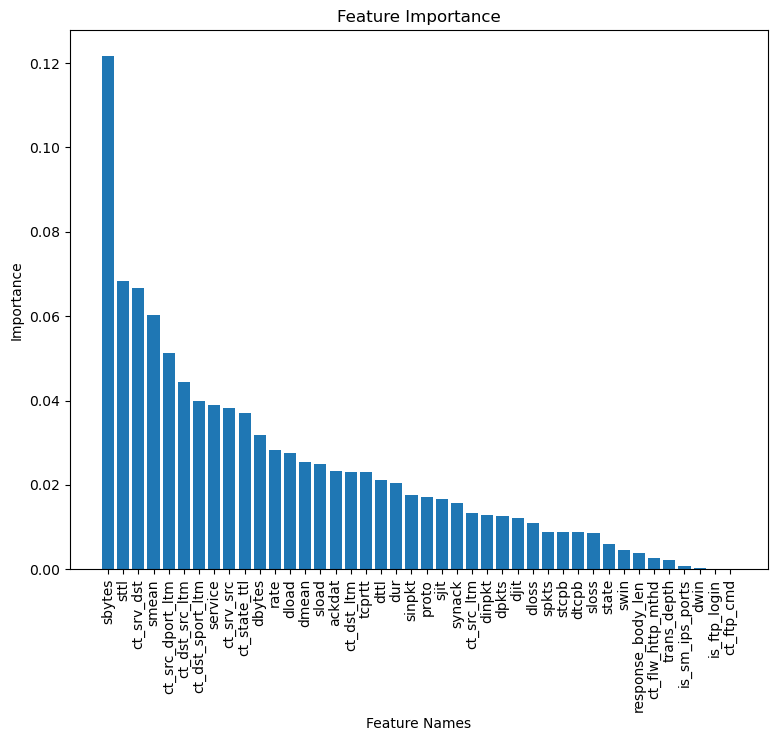

In [30]:
forest = RandomForestClassifier(n_jobs=-1, random_state=1)
forest.fit(X_oe_train_mm, y_oe_train)

# Obtain importances of each feature
importances = forest.feature_importances_

# Features ranked by importance, returns index 
indices = np.argsort(importances)[::-1]

# Plot Features vs. Importance
fig = plt.figure(figsize=(9,7))
plt.bar(range(oe_features), importances[indices], align='center') 
plt.title('Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.xticks(range(oe_features), [oe_feature_names[i] for i in indices], rotation=90) 
plt.show();

This plot helps visualize the impurity-based importance of each feature. From this, it is evident that for the initial testing of the Random Forest, **sbytes** held the greatest importance when classifying the network attacks.

---

To select the most important features, I decided to do Recursive Feature Elimination CV, as briefly shown in the model selection lecture (05_03). I will do this using the Ordinal Encoded data with the MinMaxScaler() to be able to compare it to the graph above that uses the same data.

In [31]:
%%time
selector = RFECV(forest, cv=5, scoring='balanced_accuracy', n_jobs=-1)
selector = selector.fit(X_oe_train_mm, y_oe_train)  

CPU times: total: 48min 25s
Wall time: 27min 18s


In [63]:
selected_features = selector.support_
optimal_num_features = selector.n_features_
ranking_features = selector.ranking_
estimator = selector.estimator_ 
print("Optimal Number of Features:", optimal_num_features)
print("Mask: ", selected_features)
print("Rankings: ", ranking_features)

Optimal Number of Features: 16
Mask:  [False False  True False False False  True  True  True  True False  True
  True False False False False False False False False False False False
  True False  True  True False False  True  True False  True  True  True
 False False False False  True False]
Rankings:  [ 3  8  1 19 16  9  1  1  1  1 12  1  1 14 13  7 10  4 11 21 15 17 25  5
  1  2  1  1 23 20  1  1  6  1  1  1 26 27 22 18  1 24]


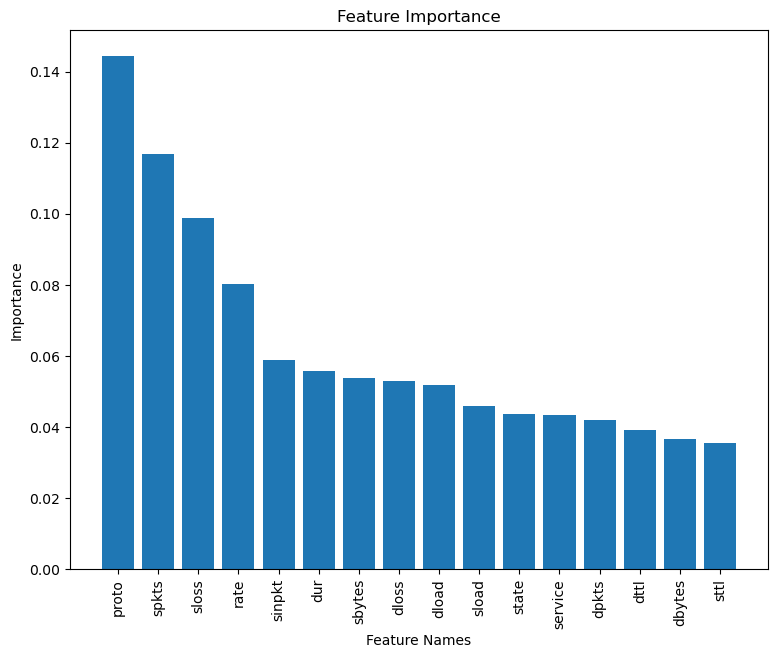

In [33]:
# Feature Importance according to RFECV

# Obtain importance of each feature
importances = estimator.feature_importances_

# Features ranked by importance, returns index 
indices = np.argsort(importances)[::-1]

# Plot Features vs. Importance
fig = plt.figure(figsize=(9,7))
plt.bar(range(0, optimal_num_features), importances[indices], align='center') 
plt.title('Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.xticks(range(0, optimal_num_features), [oe_feature_names[i] for i in indices], rotation=90) 
plt.show();

From this feature selection algorithm, we can see that the top three features are: **proto**, **spkts**, and **sloss**. This differs greatly from the previous table where the top three features are: **sbytes**, **sttl**, and **ct_srv_dst**.

##### Hyperparameter Tuning

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

After identifying and obtaining the 16 most important features (out of the 42), the next step involves doing hyper-parameter tuning on this new subset of the data.

In [55]:
%%time
outer_cv = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
accuracies = []
best_rf_list = []
best_parameters = []

for train_idx, test_idx in outer_cv.split(X_oe[:, selector.support_], y_oe):
    X_train_fold, X_test_fold = X_oe[train_idx], X_oe[test_idx]
    y_train_fold, y_test_fold = y_oe[train_idx], y_oe[test_idx]
    
    cv_inner = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

    # Create pipeline to preprocess training and validation sets
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', RandomForestClassifier())
    ])
    
    param_grid = {'classifier__n_estimators': [30, 40, 50, 60, 70, 80, 90],
                  'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'classifier__min_samples_split': [2, 5, 10],
                  'classifier__min_samples_leaf': [1, 2, 4],
                  'classifier__max_features': ['sqrt', 'log2'],
                  'classifier__bootstrap': [True, False]
                 }
    grid = RandomizedSearchCV(pipe, param_grid, scoring='balanced_accuracy', cv=cv_inner, refit=True, n_jobs=-1)
    clf = grid.fit(X_train_fold, y_train_fold)
    
    # Store best performing Random Forest Classifier
    best_rf = clf.best_estimator_
    best_rf_list.append(clf.best_estimator_)
    best_parameters.append(clf.best_params_)
    # Make predictions
    y_pred = best_rf.predict(X_test_fold)
    accuracies.append(np.mean(y_test_fold == y_pred))

CPU times: total: 1min 46s
Wall time: 8min 48s


In [56]:
print(best_rf_list[-1])
print(best_parameters[-1])
print(accuracies)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_features='log2',
                                        n_estimators=50))])
{'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__bootstrap': False}
[0.8313049147753734, 0.8297059827998385, 0.8295041758514701, 0.8308081592101586]


From the data above, the best parameters for the RandomForestClassifier seem to be:
- n_estimators: 50
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: 'log2'
- max_depth: None
- bootstrap: False

<a id='final'></a>
### [Final Phase: Evaluation of Model](#sections)

In this final evaluation, I will employ 10-cross fold validation to obtain robust estimates of the accuracies, as more folds help mitigate variance in the results, thereby providing more reliable assessments. Since I did feature selection utilizing the Ordinal Encoded data, only the accuracies from this dataset will be provided.

In [77]:
def cross_validation(X, y, preprocess=None):
    # Instantiate 10-Stratified Folds for Cross Validation
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    
    # Instantiate Random Forest classifier
    forest = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features='log2',
                                    max_depth=None, bootstrap=False, n_jobs=-1)

    # Instantiate array that will hold accuracies for each split
    accuracies = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx] # Get training data
        y_train, y_test = y[train_idx], y[test_idx] # Get testing data

        if preprocess is not None:
            X_train = preprocess.fit_transform(X_train)
            X_test = preprocess.transform(X_test)
            
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test) # Predict the test data
        accuracies.append(np.mean(y_test == y_pred))
   
    return np.mean(accuracies)

forest_oe_accuracy = []

accuracy0 = cross_validation(X_oe[:, selector.support_], y_oe)
accuracy1 = cross_validation(X_oe[:, selector.support_], y_oe, Normalizer())
accuracy2 = cross_validation(X_oe[:, selector.support_], y_oe, StandardScaler())
accuracy3 = cross_validation(X_oe[:, selector.support_], y_oe, MinMaxScaler())
accuracy4 = cross_validation(X_oe[:, selector.support_], y_oe, MaxAbsScaler())
accuracy5 = cross_validation(X_oe[:, selector.support_], y_oe, RobustScaler())
forest_oe_accuracy.append("{:.2f}%".format(accuracy0 * 100))
forest_oe_accuracy.append("{:.2f}%".format(accuracy1 * 100))
forest_oe_accuracy.append("{:.2f}%".format(accuracy2 * 100))
forest_oe_accuracy.append("{:.2f}%".format(accuracy3 * 100))
forest_oe_accuracy.append("{:.2f}%".format(accuracy4 * 100))
forest_oe_accuracy.append("{:.2f}%".format(accuracy5 * 100))

Text(0.5, 0.9, 'Ordinal Encoding')

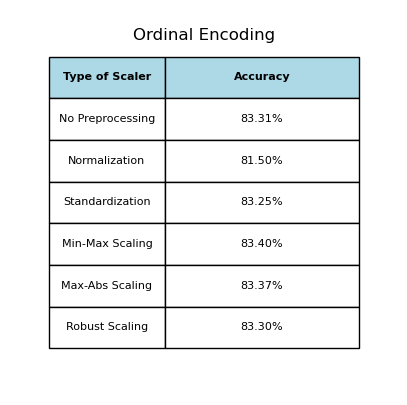

In [85]:
cell_text = np.vstack((scalers_list, forest_oe_accuracy)).T

fig = plt.figure(figsize=(5,5))
plt.rcParams['font.family'] = 'DejaVu Sans'
classes_table = plt.table(cellText=cell_text, cellLoc='center', colLabels=['Type of Scaler', 'Accuracy'], colWidths=[0.3, 0.5],
                            colColours=['lightblue', 'lightblue'], loc='center')
classes_table[0, 0].get_text().set_weight('bold')
classes_table[0, 1].get_text().set_weight('bold')
classes_table.scale(1,2.5)
classes_table.auto_set_font_size(True)
plt.axis('off')
plt.title('Ordinal Encoding', y=0.9)

**Results**: The highest accuracy attained was **83.40%** by the Min-Max Scaled data.

In [89]:
from sklearn.metrics import classification_report

In [90]:
forest = RandomForestClassifier(n_jobs=-1, random_state=1)
forest.fit(X_oe_train_mm, y_oe_train)
y_pred = forest.predict(X_oe_test_mm)

print(classification_report(y_oe_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

        Normal       0.92      0.95      0.94     18600
       Fuzzers       0.71      0.62      0.66      4849
      Analysis       0.89      0.11      0.19       535
      Backdoor       0.92      0.10      0.17       466
           DoS       0.35      0.21      0.26      3271
      Exploits       0.63      0.84      0.72      8905
       Generic       1.00      0.98      0.99     11774
Reconnaissance       0.92      0.77      0.84      2798
     Shellcode       0.65      0.69      0.67       302
         Worms       0.73      0.23      0.35        35

      accuracy                           0.83     51535
     macro avg       0.77      0.55      0.58     51535
  weighted avg       0.83      0.83      0.82     51535



<a id='binary'></a>
### [Refocusing Analysis: Normal vs. Attack](#sections)

In some scenarios, the priority shifts from needing to identify the specific type of attack to simply distinguishing between normal network traffic and illicit network traffic. That is why I have decided to further test this dataset by having 2 labels rather than 10. From this brief analysis, I expect the accuracy to increase significantly as this is only doing binary classification rather than multi-class classification. I will follow roughly the same steps as above to get a feel of how much better binary-classification does.

### Data Cleaning

In [5]:
# Clean up datasets by: 
# 1. removing id and attack_cat column
# 2. mapping categorical variables to numerical values
# 3. changing the types to float32 or int32 
def map_data(df, encoding):
    df = df.iloc[:, 1:]
    df = df.drop(columns=['attack_cat'])
    if encoding:
        df = one_hot_encoding(df)
    else:
        df = ordinal_encoding(df)
    df = type_conversion(df)
    return df

def one_hot_encoding(df):
    enc = OneHotEncoder(handle_unknown='ignore') 
    encoded_cols = enc.fit_transform(df[['proto', 'state', 'service']]).todense()
    encoded_df = pd.DataFrame(encoded_cols, columns=enc.get_feature_names_out())
    df = df.drop(columns=['proto', 'state', 'service'])
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    move_labels = df.pop("label")
    df.insert(len(df.columns), "label", move_labels)
    return df

def ordinal_encoding(df):
    enc = OrdinalEncoder()
    df[['proto', 'state', 'service']] = enc.fit_transform(df[['proto', 'state', 'service']])
    return df

def type_conversion(df):
    float64_cols = list(df.select_dtypes(include='float64'))
    df[float64_cols] = df[float64_cols].astype('float32')
    int64_cols = list(df.select_dtypes(include='int64'))
    df[int64_cols] = df[int64_cols].astype('int32')
    return df
    
def split_data(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return np.array(X), np.array(y).ravel()

In [6]:
# Read training and testing set as pandas dataframes
training_df = pd.read_csv('training.csv')
testing_df = pd.read_csv('testing.csv')

# Save data from original dataset for future plotting
original_examples = training_df.shape[0] + testing_df.shape[0]
original_features = training_df.shape[1] - 2
original_feature_names = training_df.columns.tolist()[:-2]
original_labels = training_df['label'].unique()

# Remove example with missing 'state' value (faulty example) from training set
training_df = training_df.drop(20808)

# Combine dataframes into one
merged_df = pd.concat([training_df, testing_df])

# Clean training and testing set: Apply One-Hot Encoding
merged_df_ohe = map_data(merged_df, True)

# Clean training and testing set: Apply Ordinal Encoding
merged_df_oe = map_data(merged_df, False)

# Convert dataframe to X matrix with y labels
X_ohe, y_ohe = split_data(merged_df_ohe)
X_oe, y_oe = split_data(merged_df_oe)

# Save data from One-Hot Encoded dataset for future plotting
ohe_examples = X_ohe.shape[0]
ohe_features = X_ohe.shape[1]
ohe_feature_names = merged_df_ohe.columns.tolist()[:-1]
ohe_labels = np.unique(y_ohe)

# Save data from Ordinal Encoded dataset for future plotting
oe_examples = X_oe.shape[0]
oe_features = X_oe.shape[1]
oe_feature_names = merged_df_oe.columns.tolist()[:-1]
oe_labels = np.unique(y_oe)

In [7]:
# Plot table comparing original vs. updated dataset
data = {'Examples(#)' : ["{:,}".format(original_examples), "{:,}".format(ohe_examples), "{:,}".format(oe_examples)],
        'Features' : [original_feature_names, ohe_feature_names, oe_feature_names],
        'Features(#)' : [original_features, ohe_features, oe_features],
        'Labels' : [original_labels, ohe_labels, oe_labels]}
data_info = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
data_info = data_info.rename(index={0: 'Original Dataset', 1: 'One Hot Encoded Dataset', 2: 'Ordinal Encoded Dataset'})
data_info

,Examples(#),Features,Features(#),Labels
Original Dataset,"257,673","[id, dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports]",43,"[0, 1]"
One Hot Encoded Dataset,"257,672","[dur, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports, proto_3pc, proto_a/n, proto_aes-sp3-d, proto_any, proto_argus, proto_aris, proto_arp, proto_ax.25, proto_bbn-rcc, proto_bna, proto_br-sat-mon, proto_cbt, proto_cftp, proto_chaos, proto_compaq-peer, proto_cphb, proto_cpnx, proto_crtp, proto_crudp, proto_dcn, proto_ddp, proto_ddx, proto_dgp, proto_egp, proto_eigrp, proto_emcon, proto_encap, proto_etherip, proto_fc, proto_fire, proto_ggp, proto_gmtp, proto_gre, proto_hmp, proto_i-nlsp, proto_iatp, proto_ib, proto_icmp, proto_idpr, proto_idpr-cmtp, proto_idrp, proto_ifmp, proto_igmp, proto_igp, proto_il, proto_ip, proto_ipcomp, proto_ipcv, proto_ipip, proto_iplt, proto_ipnip, proto_ippc, proto_ipv6, proto_ipv6-frag, proto_ipv6-no, proto_ipv6-opts, proto_ipv6-route, proto_ipx-n-ip, proto_irtp, proto_isis, proto_iso-ip, ...]",195,"[0, 1]"
Ordinal Encoded Dataset,"257,672","[dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports]",42,"[0, 1]"


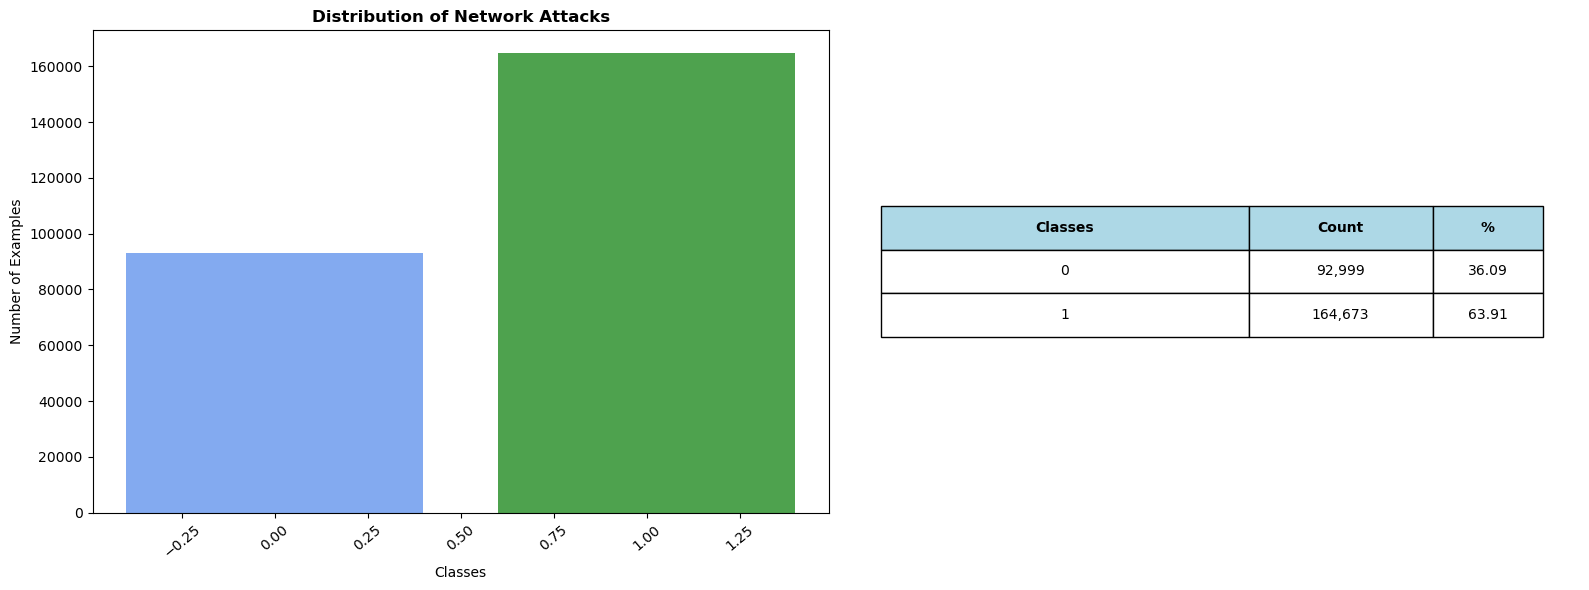

In [110]:
# Plot distribution of classes
formatted_counts = []
class_counts = []
class_names = [0,1]
percentage = []

count0 = np.sum(y_ohe == 0)
count1 = np.sum(y_ohe == 1)

class_counts.append(np.sum(y_ohe == 0))
class_counts.append(np.sum(y_ohe == 1))
formatted_counts.append("{:,}".format(count0))
formatted_counts.append("{:,}".format(count1))
percentage.append("{:.2f}".format((count0 / 257672)*100))
percentage.append("{:.2f}".format((count1 / 257672)*100))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'

# Bar Graph
colors = ['cornflowerblue', 'forestgreen']
ax[0].bar(class_names, class_counts, alpha=0.8, color=colors)
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Examples')
ax[0].set_title('Distribution of Network Attacks').set_weight('bold')
ax[0].tick_params(axis='x', rotation=40)

# Table
cell_text = np.vstack((class_names, formatted_counts, percentage)).T
classes_table = ax[1].table(cellText=cell_text, cellLoc='center', colLabels=['Classes', 'Count', '%'], colWidths=[1, 0.5, 0.3],
                            colColours=['lightblue', 'lightblue', 'lightblue'], loc='center')

classes_table[0, 0].get_text().set_weight('bold')
classes_table[0, 1].get_text().set_weight('bold')
classes_table[0, 2].get_text().set_weight('bold')

classes_table.scale(0.5,2.5)
classes_table.auto_set_font_size(True)
ax[1].axis('off')
plt.tight_layout()
plt.show();

### Data Preprocessing

In [112]:
# For One-Hot Encoded dataset

# Shuffle and stratify 
X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y_ohe, test_size=0.2, stratify=y_ohe, shuffle=True, random_state=1)

transformer = Normalizer()
X_ohe_train_norm = transformer.fit_transform(X_ohe_train)
X_ohe_test_norm = transformer.transform(X_ohe_test)

scaler = StandardScaler()
X_ohe_train_std = scaler.fit_transform(X_ohe_train)
X_ohe_test_std = scaler.transform(X_ohe_test)

mmScaler = MinMaxScaler()
X_ohe_train_mm = mmScaler.fit_transform(X_ohe_train)
X_ohe_test_mm = mmScaler.transform(X_ohe_test)

maScaler = MaxAbsScaler()
X_ohe_train_ma = maScaler.fit_transform(X_ohe_train)
X_ohe_test_ma = maScaler.transform(X_ohe_test)

rScaler = RobustScaler()
X_ohe_train_r = rScaler.fit_transform(X_ohe_train)
X_ohe_test_r = rScaler.transform(X_ohe_test)

print("Training set shape for One-Hot Encoding:", X_ohe_train.shape)

# For Ordinal Encoded dataset
X_oe_train, X_oe_test, y_oe_train, y_oe_test = train_test_split(X_oe, y_oe, test_size=0.2, stratify=y_oe, shuffle=True, random_state=1)

X_oe_train_norm = transformer.fit_transform(X_oe_train)
X_oe_test_norm = transformer.transform(X_oe_test)

X_oe_train_std = scaler.fit_transform(X_oe_train)
X_oe_test_std = scaler.transform(X_oe_test)

X_oe_train_mm = mmScaler.fit_transform(X_oe_train)
X_oe_test_mm = mmScaler.transform(X_oe_test)

X_oe_train_ma = maScaler.fit_transform(X_oe_train)
X_oe_test_ma = maScaler.transform(X_oe_test)

X_oe_train_r = rScaler.fit_transform(X_oe_train)
X_oe_test_r = rScaler.transform(X_oe_test)

print("Training set shape for Ordinal Encoding:", X_oe_train.shape)

Training set shape for One-Hot Encoding: (206137, 195)
Training set shape for Ordinal Encoding: (206137, 42)


In [113]:
def evaluate_accuracy(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(n_jobs=-1, random_state=1)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    return np.mean(y_test == y_pred)

X_ohe_train_data = [
    [X_ohe_train, X_ohe_test], 
    [X_ohe_train_norm, X_ohe_test_norm], 
    [X_ohe_train_std, X_ohe_test_std], 
    [X_ohe_train_mm, X_ohe_test_mm], 
    [X_ohe_train_ma, X_ohe_test_ma], 
    [X_ohe_train_r, X_ohe_test_r]
]

X_oe_train_data = [
    [X_oe_train, X_oe_test], 
    [X_oe_train_norm, X_oe_test_norm], 
    [X_oe_train_std, X_oe_test_std], 
    [X_oe_train_mm, X_oe_test_mm],  
    [X_oe_train_ma, X_oe_test_ma], 
    [X_oe_train_r, X_oe_test_r]
]

forest_ohe_accuracy = []
forest_oe_accuracy = []

for X_p in X_ohe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_ohe_train, y_ohe_test)
    forest_ohe_accuracy.append("{:.2f}%".format(accuracy * 100))
    
for X_p in X_oe_train_data:
    accuracy = evaluate_accuracy(X_p[0], X_p[1], y_oe_train, y_oe_test)
    forest_oe_accuracy.append("{:.2f}%".format(accuracy * 100))

cell_text = np.vstack((scalers_list, forest_ohe_accuracy)).T
cell_text2 = np.vstack((scalers_list, forest_oe_accuracy)).T

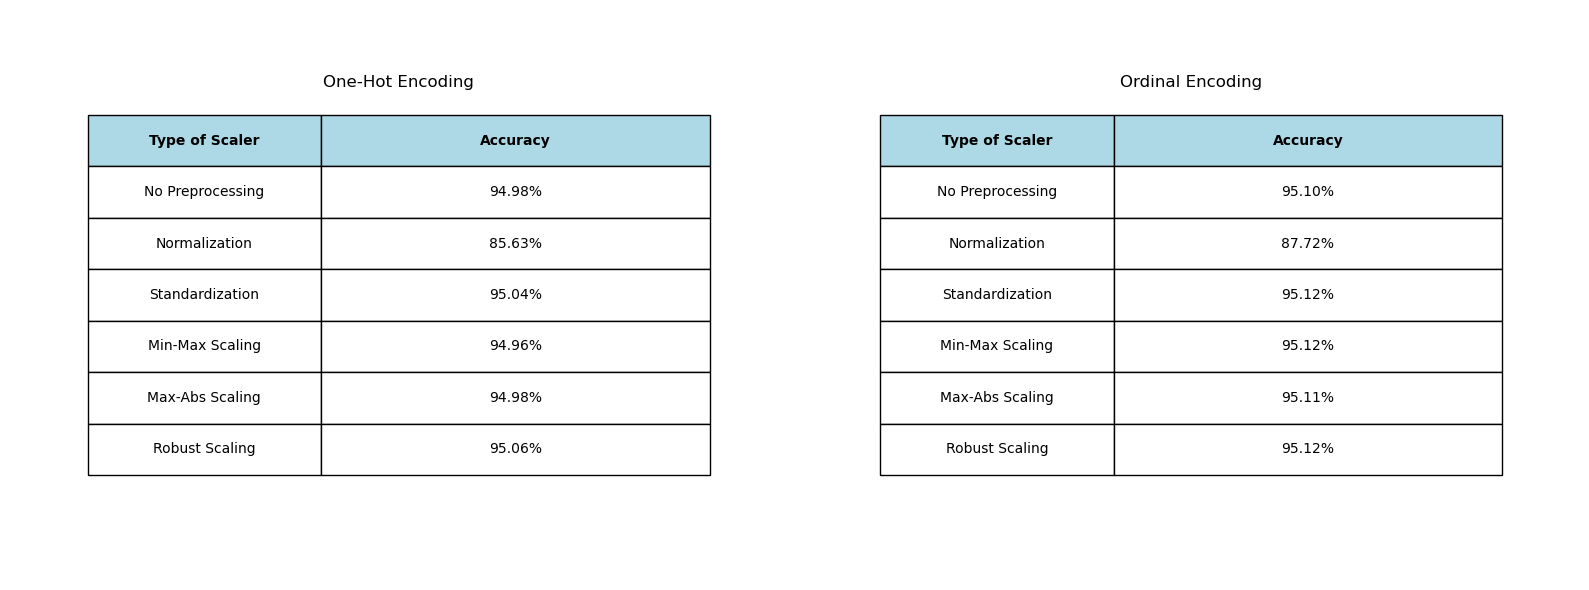

In [114]:
accuracy_table(cell_text, cell_text2)

From this brief analysis, it can be perceived that binary classification yields superior performance, with the highest accuracy being **95.12%** using only default parameters. In terms of the confusion matrix, it can be seen that roughly ~2000 get misclassified. This performance can be improved with Data Analysis, Feature Selection, and Hyperparameter tuning.

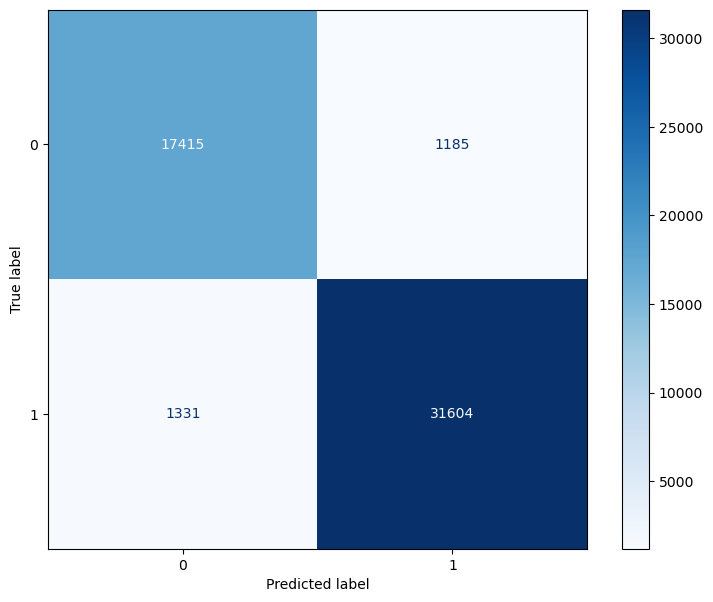

In [116]:
# Use Ordinal Encoding with Standardization
forest = RandomForestClassifier(n_jobs=-1, random_state=1)
forest.fit(X_oe_train_std, y_oe_train)
y_pred = forest.predict(X_oe_test_std)
matrix = confusion_matrix(y_oe_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(9,7))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

<a id='conclusion'></a>
# [Conclusion](#sections)

In this report, I have delved into the UNSW-NB15 Dataset, a dataset created in order to reflect modern network traffic scenarios. Throughout the making of this project, I learned that a substantial portion of designing a machine learning model involves data analysis. As I guided myself with course material and my own research, I have come to appreciate the multitude of things to consider when analyzing and selecting features, along with the many tools available to aid in this process. I have also become more familiarized with the tools introduced in this course, such as matplotlib, pandas, numpy, and sklearn. Concerning ML concepts, this project has deepened my understanding of PCA, t-SNE, feature selection, and hyperparameter tuning. Looking ahead, I am eager to learn more and apply the knowledge I have acquired.

<a id='references'></a>
## [<center>References</center>](#sections)

\[1]&emsp;C. Jeffray and T. Feakin, "Underground Web: The Cybercrime Challenge," *Australian Strategic Policy Institute*, 2015. \[Online]. Available: [http://www.jstor.org/stable/resrep04074](http://www.jstor.org/stable/resrep04074). Accessed April 15, 2024.

\[2]&emsp;F. Mabrouk, "Statistics of Cybercrime from 2016 to the First Half of 2020," *International Journal of Computer Science and Network*, vol. 9, no. 5, October 2020, doi: [10.13140/RG.2.2.30131.66088](https://doi.org/10.13140/RG.2.2.30131.66088).

\[3]&emsp;N. Moustafa and J. Slay, "UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)," *2015 Military Communications and Information Systems Conference (MilCIS)*, Canberra, ACT, Australia, 2015, pp. 1-6, doi: [10.1109/MilCIS.2015.7348942](https://doi.org/10.1109/MilCIS.2015.7348942).

\[4]&emsp;N. Moustafa and J. Slay, "The evaluation of Network Anomaly Detection Systems: Statistical analysis of the UNSW-NB15 data set and the comparison with the KDD99 data set," *Information Security Journal: A Global Perspective*, vol. 25, no. 1–3, pp. 18–31, 2016, doi: [10.1080/19393555.2015.1125974](https://doi.org/10.1080/19393555.2015.1125974).

\[5]&emsp;N. Moustafa, J. Slay and G. Creech, "Novel Geometric Area Analysis Technique for Anomaly Detection Using Trapezoidal Area Estimation on Large-Scale Networks," in *IEEE Transactions on Big Data*, vol. 5, no. 4, pp. 481-494, 1 Dec. 2019, doi: [10.1109/TBDATA.2017.2715166](https://doi.org/10.1109/TBDATA.2017.2715166).

\[6]&emsp;N. Moustafa, G. Creech, and J. Slay, "Big Data Analytics for Intrusion Detection System: Statistical Decision-Making Using Finite Dirichlet Mixture Models," in *Data Analytics and Decision Support for Cybersecurity*, I. Palomares Carrascosa, H. Kalutarage, and Y. Huang, Eds., Cham: Springer, 2017, pp. 69–84, doi: [10.1007/978-3-319-59439-2_5](https://doi.org/10.1007/978-3-319-59439-2_5).

\[7]&emsp;M. Sarhan, S. Layeghy, N. Moustafa, and M. Portmann, "NetFlow Datasets for Machine Learning-Based Network Intrusion Detection Systems," in *Big Data Technologies and Applications: 10th EAI International Conference, BDTA 2020, and 13th EAI International Conference on Wireless Internet, WiCON 2020, Virtual Event, December 11, 2020, Proceedings*, Z. Deze, H. Huang, R. Hou, S. Rho, and N. Chilamkurti, Eds., Lecture Notes of the Institute for Computer Sciences, Social Informatics and Telecommunications Engineering, vol. 371, Cham: Springer, 2021, doi: [10.1007/978-3-030-72802-1_9](https://doi.org/10.1007/978-3-030-72802-1_9).

\[8]&emsp;M. Boehme, C. Cadar and A. ROYCHOUDHURY, "Fuzzing: Challenges and Reflections," in *IEEE Software*, vol. 38, no. 3, pp. 79-86, May-June 2021, doi: [10.1109/MS.2020.3016773](https://doi.org/10.1109/MS.2020.3016773).

\[9]&emsp;Y. FarzaneNia and A. Nowroozi, "Behavior and system based backdoor detection focusing on CMD phase," *2015 12th International Iranian Society of Cryptology Conference on Information Security and Cryptology (ISCISC)*, Rasht, Iran, 2015, pp. 128-133, doi: [10.1109/ISCISC.2015.7387910](https://doi.org/10.1109/ISCISC.2015.7387910).

\[10]&emsp;K. S. Vanitha, S. V. UMA and S. K. Mahidhar, "Distributed denial of service: Attack techniques and mitigation," *2017 International Conference on Circuits, Controls, and Communications (CCUBE)*, Bangalore, India, 2017, pp. 226-231, doi: [10.1109/CCUBE.2017.8394146](https://doi.org/10.1109/CCUBE.2017.8394146).

\[11]&emsp;R. Chadha, G. S. Shalom, V. K. Anand and A. Goel, "A Study on Exploit Development," 2022 7th International Conference on Computing, Communication and Security (ICCCS), Seoul, Korea, Republic of, 2022, pp. 1-7, doi: [10.1109/ICCCS55188.2022.10079387](https://doi.org/10.1109/ICCCS55188.2022.10079387).

\[12]&emsp;“What Are Footprinting and Reconnaissance?,” Cybersecurity Exchange. \[Online]. Available: [https://www.eccouncil.org/cybersecurity-exchange/ethical-hacking/basics-footprinting-reconnaissance](https://www.eccouncil.org/cybersecurity-exchange/ethical-hacking/basics-footprinting-reconnaissance). Accessed: April 11, 2024. 

\[13]&emsp;I. Arce, "The shellcode generation," in *IEEE Security & Privacy*, vol. 2, no. 5, pp. 72-76, Sept.-Oct. 2004, doi: [10.1109/MSP.2004.87](https://doi.org/10.1109/MSP.2004.87).

\[14]&emsp;V. S. Koganti, L. K. Galla and N. Nuthalapati, "Internet worms and its detection," 2016 International Conference on Control, Instrumentation, Communication and Computational Technologies (ICCICCT), Kumaracoil, India, 2016, pp. 64-73, doi: [10.1109/ICCICCT.2016.7987920](https://doi.org/10.1109/ICCICCT.2016.7987920).